# 0 Install and Import libraries

In [ ]:
!pip install tslearn fastdtw lightgbm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 14.4 MB/s eta 0:00:00


In [ ]:
# Core libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

# Time series and DTW tools
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score

# Prediction
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error, r2_score,root_mean_squared_error,root_mean_squared_log_error

# Optional visualization
import seaborn as sns

# 1.Load dataset

In [ ]:
# Mount my drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read the dataset
# Upload the dataset and change the path to your own one.
data_path = "/content/drive/My Drive/Appled-Data-Science/Data/SeoulBikeData.csv"
try:
    df = pd.read_csv(data_path, encoding='cp949')
    display(df.head())
except FileNotFoundError:
    print("File not found. Please check the file path.")
except UnicodeDecodeError:
    print("Could not decode the file using cp949. Please try a different encoding.")

Date  Rented Bike Count  Hour  Temperature(캜)  Humidity(%)  \
0  01/12/2017                254     0            -5.2           37   
1  01/12/2017                204     1            -5.5           38   
2  01/12/2017                173     2            -6.0           39   
3  01/12/2017                107     3            -6.2           40   
4  01/12/2017                 78     4            -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(캜)  \
0               2.2              2000                     -17.6   
1               0.8              2000                     -17.6   
2               1.0              2000                     -17.7   
3               0.9              2000                     -17.6   
4               2.3              2000                     -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

# 2.Data Prepossessing

In [ ]:
# Rename the columns
new_columns = ["date","hourly_count","hour","temperature","humidity","wind_speed","visibility","dew_point_temperature","solar_radiation","rainfall","sonwfall","seasons","holiday","functioning_day"]
df.columns = new_columns
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['hour'] = df['hour'].astype(int)
df = df.replace({"No Holiday": "non_holiday", "Holiday": "holiday"})
df.head()


date  hourly_count  hour  temperature  humidity  wind_speed  \
0 2017-12-01           254     0         -5.2        37         2.2   
1 2017-12-01           204     1         -5.5        38         0.8   
2 2017-12-01           173     2         -6.0        39         1.0   
3 2017-12-01           107     3         -6.2        40         0.9   
4 2017-12-01            78     4         -6.0        36         2.3   

   visibility  dew_point_temperature  solar_radiation  rainfall  sonwfall  \
0        2000                  -17.6              0.0       0.0       0.0   
1        2000                  -17.6              0.0       0.0       0.0   
2        2000                  -17.7              0.0       0.0       0.0   
3        2000                  -17.6              0.0       0.0       0.0   
4        2000                  -18.6              0.0       0.0       0.0   

  seasons      holiday functioning_day  
0  Winter  non_holiday             Yes  
1  Winter  non_holiday             Yes  
2  Winter  non_holiday             Yes  
3  Winter  non_holiday             Yes  
4  Winter  non_holiday             Yes

In [ ]:
df.isna().sum()

date                     0
hourly_count             0
hour                     0
temperature              0
humidity                 0
wind_speed               0
visibility               0
dew_point_temperature    0
solar_radiation          0
rainfall                 0
sonwfall                 0
seasons                  0
holiday                  0
functioning_day          0
month                    0
weekday                  0
dtype: int64

# 3.EDA

Text(0.5, 1.0, 'Rented Bike Count Over Time')

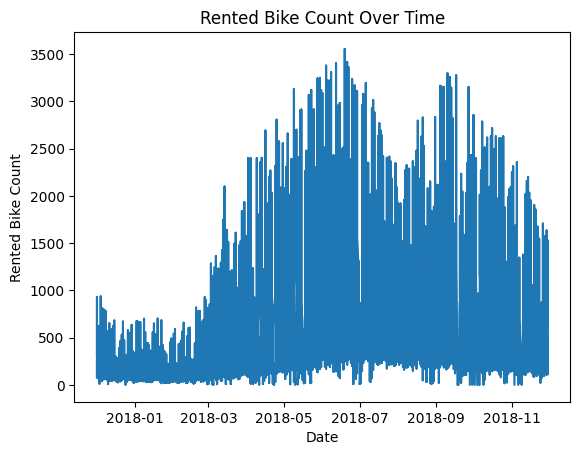

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
plt.plot(df['date'], df['hourly_count'])
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.title('Rented Bike Count Over Time')

date
2017-12-03    25284
2017-12-10    50972
2017-12-17    39367
2017-12-24    33078
2017-12-31    36629
Freq: W-SUN, Name: hourly_count, dtype: int64

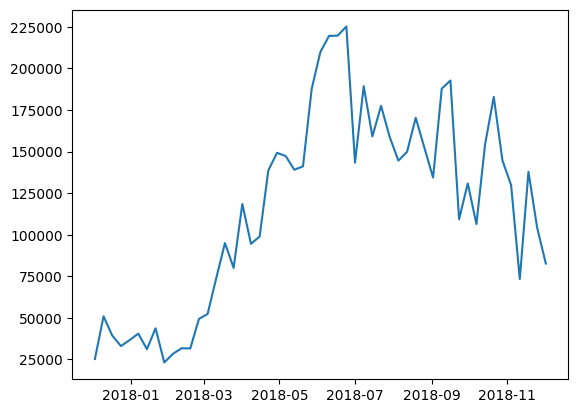

In [ ]:
weekly_sum = df.groupby(pd.Grouper(key='date', freq='W'))['hourly_count'].sum()
display(weekly_sum.head())
plt.plot(weekly_sum)

/tmp/ipython-input-3248344613.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sum = df.groupby(pd.Grouper(key='date', freq='M'))['hourly_count'].sum()


date
2017-12-31    185330
2018-01-31    150006
2018-02-28    151833
2018-03-31    380594
2018-04-30    524227
Freq: ME, Name: hourly_count, dtype: int64

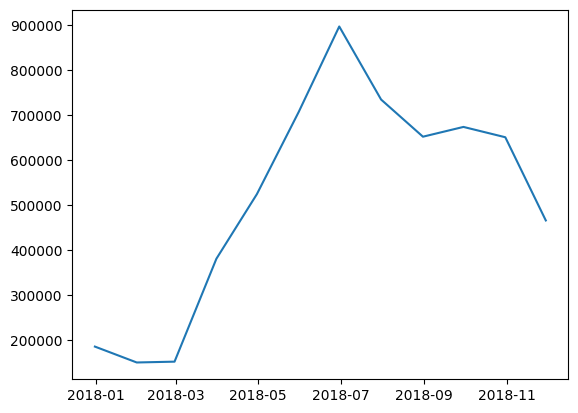

In [ ]:
monthly_sum = df.groupby(pd.Grouper(key='date', freq='M'))['hourly_count'].sum()
display(monthly_sum.head())
plt.plot(monthly_sum)

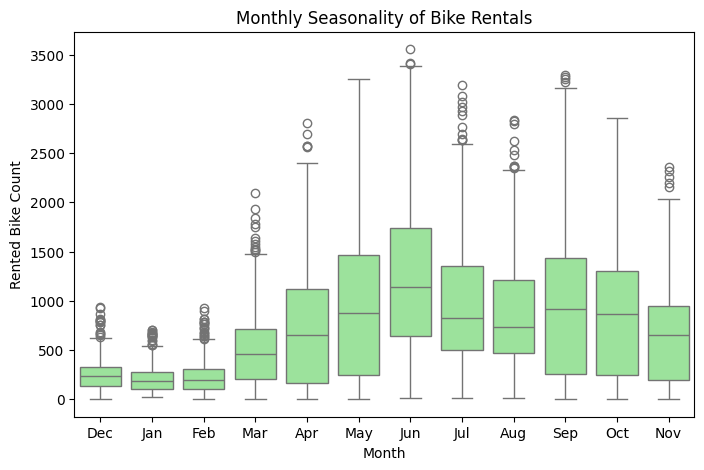

In [ ]:
# month and weekday columns ---
df['month'] = df['date'].dt.month_name().str[:3]
df['weekday'] = df['date'].dt.day_name()
df['hour'] = df['hour'].astype(int)

# Monthly seasonality
plt.figure(figsize=(8,5))
sns.boxplot(x='month', y='hourly_count', data=df, color='lightgreen')
plt.title("Monthly Seasonality of Bike Rentals")
plt.xlabel("Month")
plt.ylabel("Rented Bike Count")
plt.show()


In [ ]:
df_grouped = df.groupby(['date', 'hour'])['hourly_count'].mean().reset_index()
display(df_grouped.head())

date  hour  hourly_count
0 2017-12-01     0         254.0
1 2017-12-01     1         204.0
2 2017-12-01     2         173.0
3 2017-12-01     3         107.0
4 2017-12-01     4          78.0

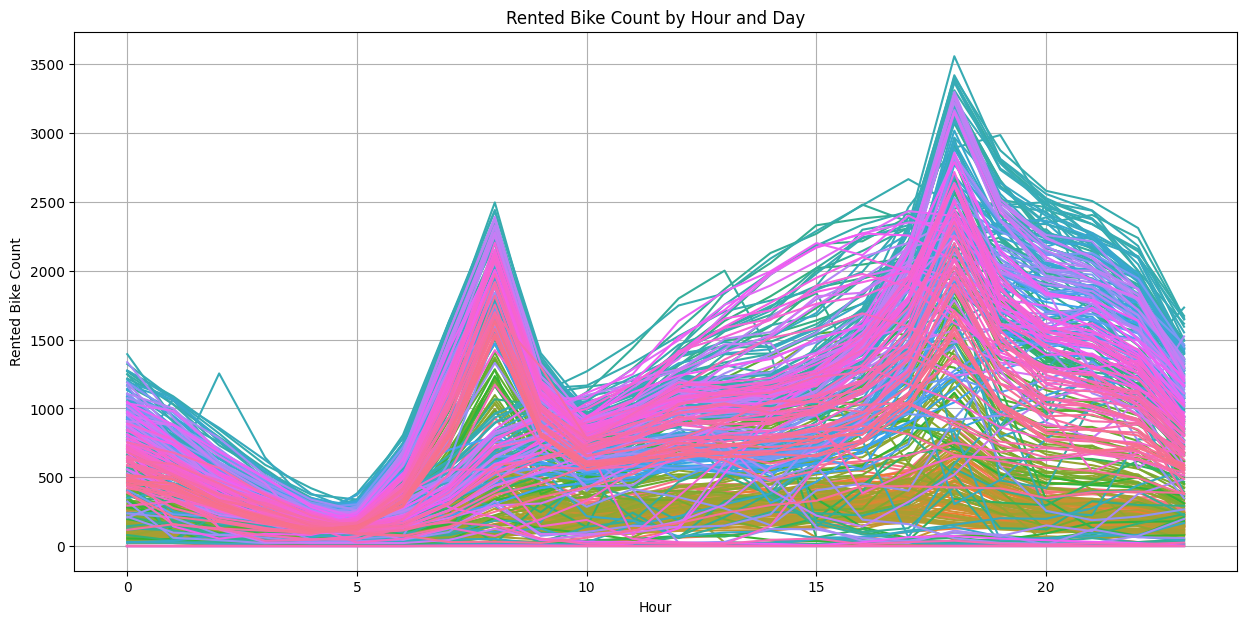

In [ ]:
# Explore the pattern of hourly rented bike count
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_grouped, x='hour', y='hourly_count', hue='date', legend=False)
plt.title('Rented Bike Count by Hour and Day')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the ratio of hourly count
daily_sum = df.groupby(['date'])['hourly_count'].sum().reset_index()
daily_sum.columns = ['date', 'daily_count']
daily_sum.head()

date  daily_count
0 2017-12-01         9539
1 2017-12-02         8523
2 2017-12-03         7222
3 2017-12-04         8729
4 2017-12-05         8307

In [ ]:
df = df.merge(daily_sum, on='date', how='left')
df['hourly_ratio'] = df['hourly_count'] / df['daily_count']
# fill the na with 0
df['hourly_ratio'] = df['hourly_ratio'].fillna(0)

In [ ]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ':00:00')
df.set_index('datetime', inplace=True)
df.head()

date  hourly_count  hour  temperature  humidity  \
datetime                                                                    
2017-12-01 00:00:00 2017-12-01           254     0         -5.2        37   
2017-12-01 01:00:00 2017-12-01           204     1         -5.5        38   
2017-12-01 02:00:00 2017-12-01           173     2         -6.0        39   
2017-12-01 03:00:00 2017-12-01           107     3         -6.2        40   
2017-12-01 04:00:00 2017-12-01            78     4         -6.0        36   

                     wind_speed  visibility  dew_point_temperature  \
datetime                                                             
2017-12-01 00:00:00         2.2        2000                  -17.6   
2017-12-01 01:00:00         0.8        2000                  -17.6   
2017-12-01 02:00:00         1.0        2000                  -17.7   
2017-12-01 03:00:00         0.9        2000                  -17.6   
2017-12-01 04:00:00         2.3        2000                  -18.6   

                     solar_radiation  rainfall  sonwfall seasons      holiday  \
datetime                                                                        
2017-12-01 00:00:00              0.0       0.0       0.0  Winter  non_holiday   
2017-12-01 01:00:00              0.0       0.0       0.0  Winter  non_holiday   
2017-12-01 02:00:00              0.0       0.0       0.0  Winter  non_holiday   
2017-12-01 03:00:00              0.0       0.0       0.0  Winter  non_holiday   
2017-12-01 04:00:00              0.0       0.0       0.0  Winter  non_holiday   

                    functioning_day month weekday  daily_count  hourly_ratio  
datetime                                                                      
2017-12-01 00:00:00             Yes   Dec  Friday         9539      0.026628  
2017-12-01 01:00:00             Yes   Dec  Friday         9539      0.021386  
2017-12-01 02:00:00             Yes   Dec  Friday         9539      0.018136  
2017-12-01 03:00:00             Yes   Dec  Friday         9539      0.011217  
2017-12-01 04:00:00             Yes   Dec  Friday         9539      0.008177

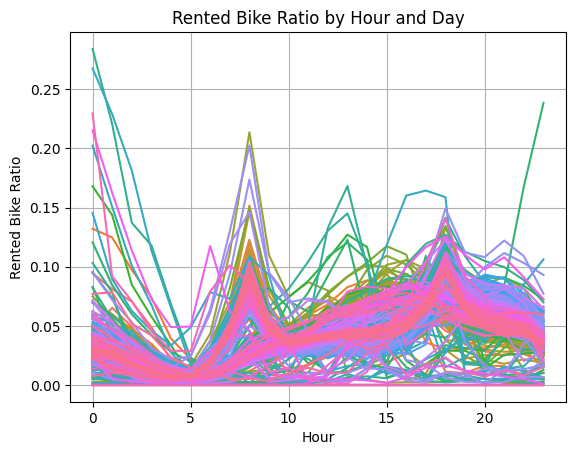

In [ ]:
# Plot the mean of hourly ratio, showing the pattern of hourly count
hourly_ratio_mean = df.groupby('hour')['hourly_ratio'].mean()
sns.lineplot(data=df, x='hour', y='hourly_ratio', hue='date', legend=False)
plt.title('Rented Bike Ratio by Hour and Day')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Ratio')
plt.grid(True)
plt.show()

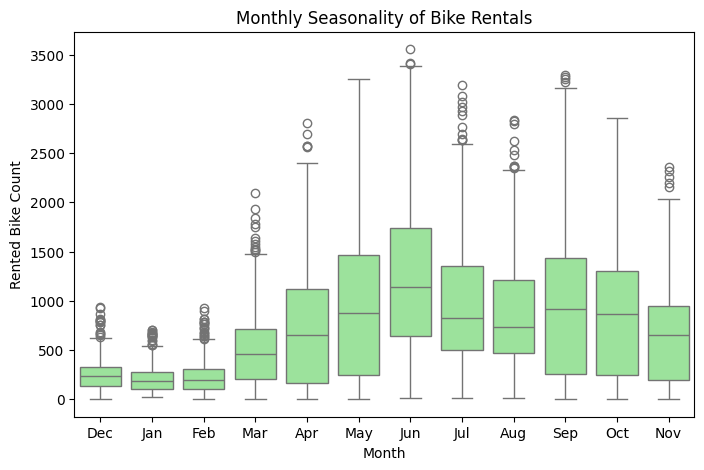

In [ ]:
# month and weekday columns ---
df['month'] = df['date'].dt.month_name().str[:3]
df['weekday'] = df['date'].dt.day_name()
df['hour'] = df['hour'].astype(int)

# Monthly seasonality
plt.figure(figsize=(8,5))
sns.boxplot(x='month', y='hourly_count', data=df, color='lightgreen')
plt.title("Monthly Seasonality of Bike Rentals")
plt.xlabel("Month")
plt.ylabel("Rented Bike Count")
plt.show()


/tmp/ipython-input-2157166101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='holiday', y='hourly_count', data=df, palette=['lightcoral','turquoise'])


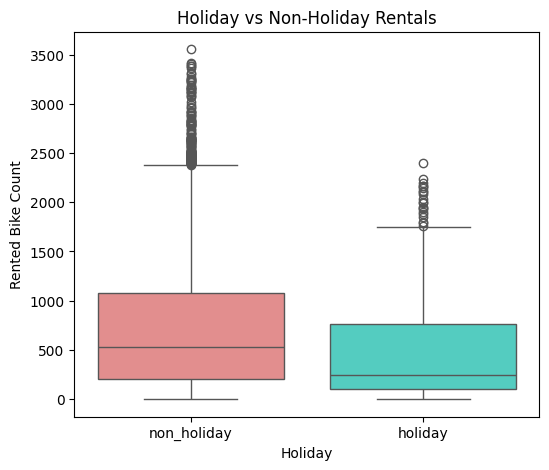

In [ ]:
#  Holiday vs Non-Holiday
plt.figure(figsize=(6,5))
sns.boxplot(x='holiday', y='hourly_count', data=df, palette=['lightcoral','turquoise'])
plt.title("Holiday vs Non-Holiday Rentals")
plt.xlabel("Holiday")
plt.ylabel("Rented Bike Count")
plt.show()

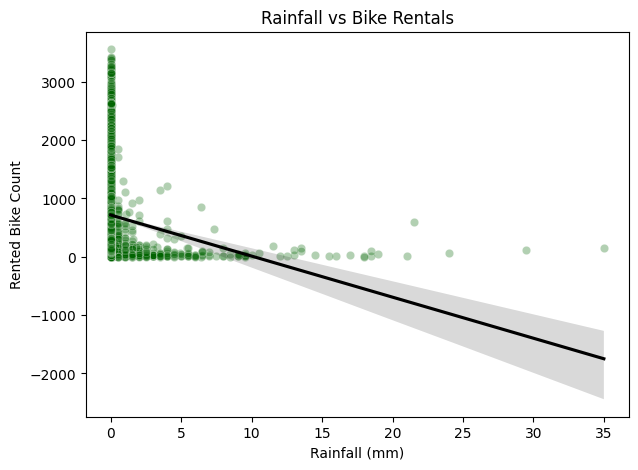

In [ ]:
# Rainfall vs Rented Bike Count
# There is no linear relation between these two variables
plt.figure(figsize=(7,5))
sns.scatterplot(x='rainfall', y='hourly_count', data=df, alpha=0.3, color='darkgreen')
sns.regplot(x='rainfall', y='hourly_count', data=df, scatter=False, color='black')
plt.title("Rainfall vs Bike Rentals")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Rented Bike Count")
plt.show()

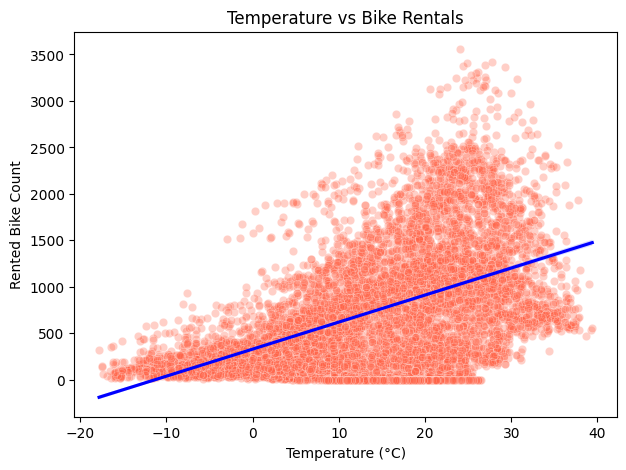

In [ ]:
# Temperature vs Rented Bike Count
# It shows that no linear relation between these two variables
plt.figure(figsize=(7,5))
sns.scatterplot(x='temperature', y='hourly_count', data=df, alpha=0.3, color='tomato')
sns.regplot(x='temperature', y='hourly_count', data=df, scatter=False, color='blue')
plt.title("Temperature vs Bike Rentals")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rented Bike Count")
plt.show()

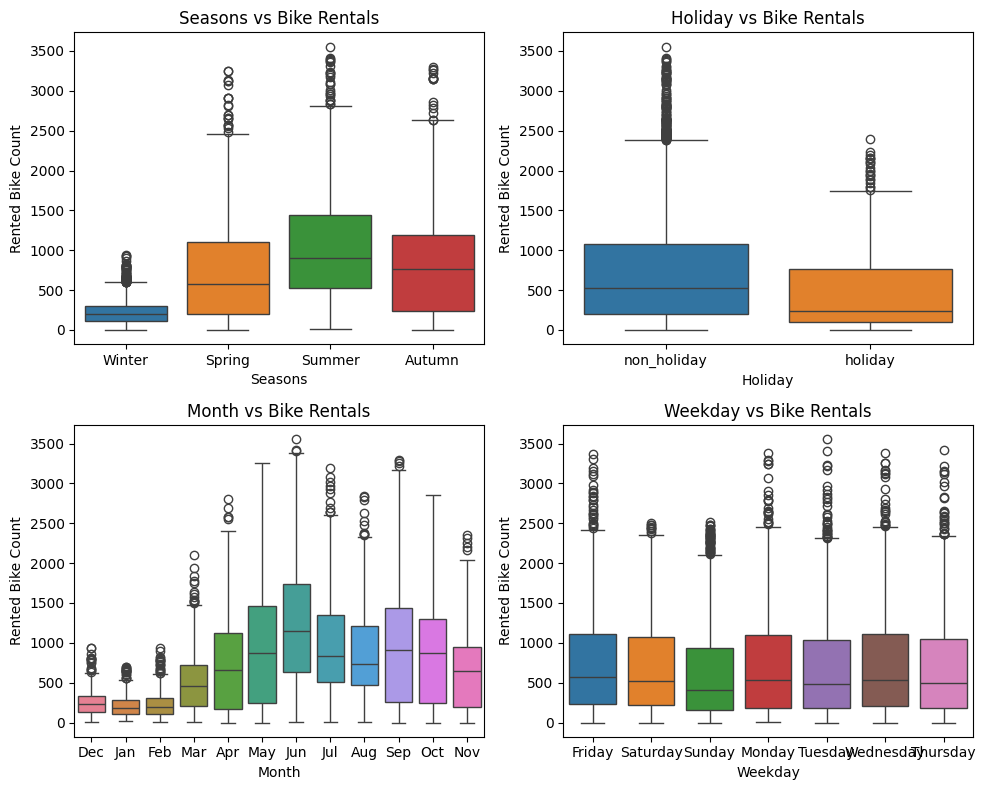

In [ ]:
# Identify numerical columns (excluding the target variable itself)
categorical_cols = df.select_dtypes(include='object').columns.tolist()

categorical_cols = [col for col in categorical_cols if col not in ["functioning_day"]]

# Determine the number of rows and columns for the grid
n_cols = 2  # You can adjust the number of columns as needed
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Create scatter plots for each numerical variable against 'hourly_count'
for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y='hourly_count', data=df, ax=axes[i], hue=col, legend=False)
    axes[i].set_title(f'{col.replace("_", " ").title()} vs Bike Rentals')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Rented Bike Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

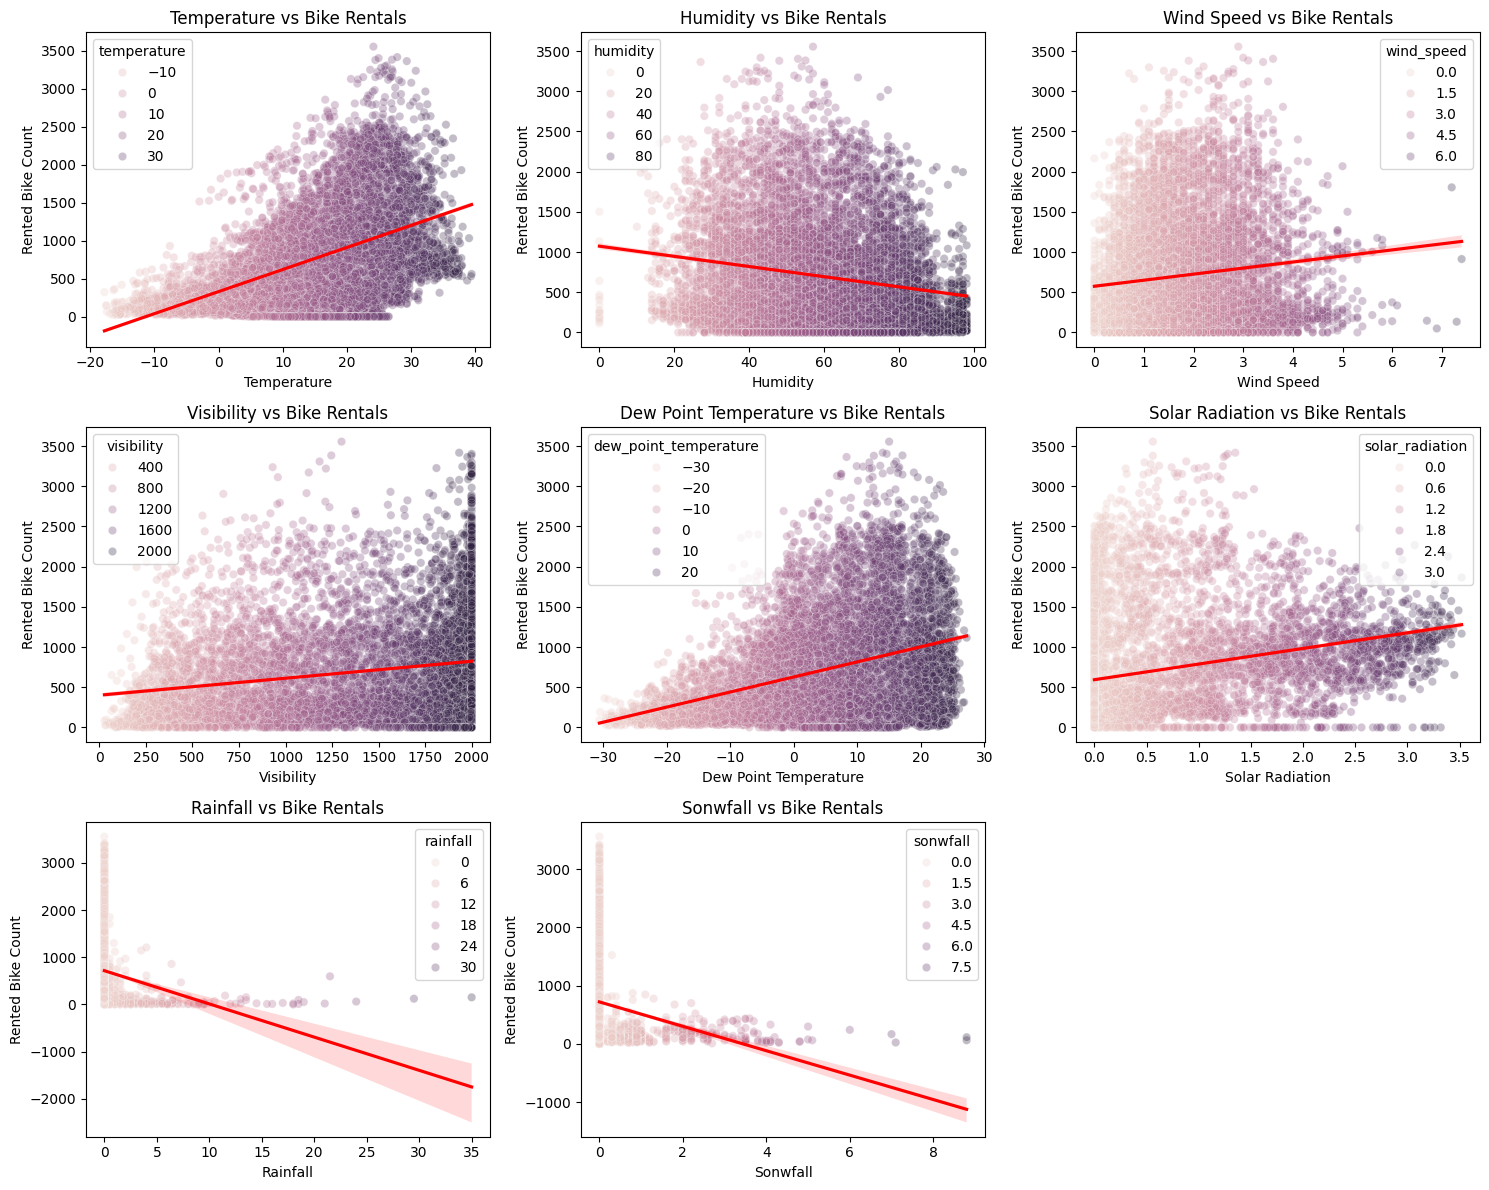

In [ ]:
# Identify numerical columns (excluding the target variable itself)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['hourly_count',"hour","daily_count","hourly_ratio"]]

# Determine the number of rows and columns for the grid
n_cols = 3  # You can adjust the number of columns as needed
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Create scatter plots for each numerical variable against 'hourly_count'
for i, col in enumerate(numerical_cols):
    sns.scatterplot(x=col, y='hourly_count', data=df, alpha=0.3, ax=axes[i],hue=col)
    sns.regplot(x=col, y='hourly_count', data=df, scatter=False, color='red', ax=axes[i]) # Add a regression line
    axes[i].set_title(f'{col.replace("_", " ").title()} vs Bike Rentals')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Rented Bike Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 4.Clustering

## 4.1 Time Series KMeans

In [ ]:
# Pivot to get 24-hour vectors per day
daily_series = df.pivot_table(index='date',
                       columns='hour',
                       values='hourly_count',
                       aggfunc='mean')  # mean guards against duplicates; hourly data usually unique

# Keep only days with all 24 hours present
daily_series = daily_series.dropna(axis=0)

# Ensure columns are sorted 0..23
daily_series = daily_series.reindex(columns=sorted(daily_series.columns))

print(f"Days retained: {daily_series.shape[0]}; Hours per day: {daily_series.shape[1]}")

Days retained: 365; Hours per day: 24


In [ ]:
# First 5 entries
daily_series.head()

hour           0      1      2      3     4      5      6      7      8   \
date                                                                       
2017-12-01  254.0  204.0  173.0  107.0  78.0  100.0  181.0  460.0  930.0   
2017-12-02  328.0  308.0  262.0  167.0  89.0   79.0   70.0  146.0  219.0   
2017-12-03  342.0  227.0  228.0  117.0  76.0   32.0   13.0   22.0   85.0   
2017-12-04  285.0  186.0  112.0   65.0  41.0   82.0  200.0  498.0  937.0   
2017-12-05  216.0  198.0  124.0   62.0  42.0   82.0  172.0  381.0  812.0   

hour           9   ...     14     15     16     17     18     19     20  \
date               ...                                                    
2017-12-01  490.0  ...  447.0  463.0  484.0  555.0  862.0  600.0  426.0   
2017-12-02  328.0  ...  611.0  589.0  618.0  572.0  489.0  385.0  359.0   
2017-12-03  152.0  ...  563.0  621.0  598.0  545.0  443.0  422.0  397.0   
2017-12-04  509.0  ...  338.0  341.0  375.0  515.0  807.0  568.0  398.0   
2017-12-05  462.0  ...  334.0  353.0  435.0  529.0  789.0  597.0  418.0   

hour           21     22     23  
date                             
2017-12-01  405.0  398.0  323.0  
2017-12-02  377.0  354.0  366.0  
2017-12-03  385.0  350.0  303.0  
2017-12-04  397.0  353.0  248.0  
2017-12-05  415.0  393.0  244.0  

[5 rows x 24 columns]

In [ ]:
# Normalize each time series (each day) to ensure clustering focuses on shape
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(daily_series.values)

After visualizing the plot, the best number of clusters to use is 3.

Also try Silhouette Score to double check. The number of clusters closest that give score closest to 1 is the best.

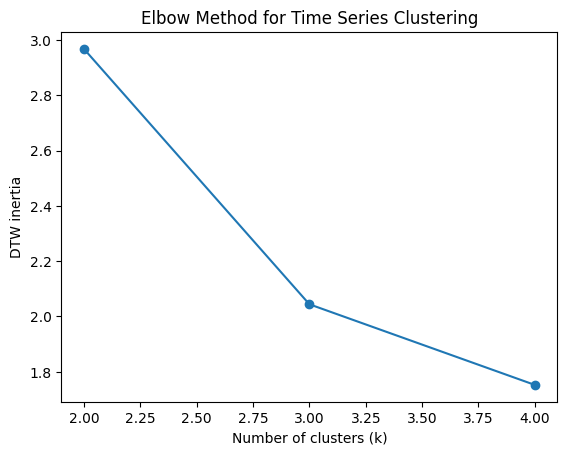

In [ ]:
# Use elbow method to determine optimal number of clusters
inertias = []
k_values = range(2, 5)  # Try between these number of clusters

for k in k_values:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(k_values, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('DTW inertia')
plt.title('Elbow Method for Time Series Clustering')
plt.show()

In [ ]:
# Fit DTW KMeans with clusters n=2
n_clusters = 2
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X_scaled)
dist_matrix = cdist_dtw(X_scaled)
score = silhouette_score(dist_matrix, labels, metric="precomputed")
print("Silhouette score:", round(score, 3))

Silhouette score: 0.424


In [ ]:
# Try with clusters n=3
n_clusters = 3
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X_scaled)
dist_matrix = cdist_dtw(X_scaled)
score = silhouette_score(dist_matrix, labels, metric="precomputed")
print("Silhouette score:", round(score, 3))

Silhouette score: 0.359


In [ ]:
# Try with clusters = 4
n_clusters = 4
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X_scaled)
dist_matrix = cdist_dtw(X_scaled)
score = silhouette_score(dist_matrix, labels, metric="precomputed")
print("Silhouette score:", round(score, 3))

Silhouette score: 0.284


In [ ]:
# Try with clusters = 5
n_clusters = 5
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X_scaled)
dist_matrix = cdist_dtw(X_scaled)
score = silhouette_score(dist_matrix, labels, metric="precomputed")
print("Silhouette score:", round(score, 3))

Silhouette score: 0.308


From the Silhouette scores, we can see that n=2 provides a score closer to 1 than when n=3. (We will disregard n=4 and n=5 because they are both lower.)

Generally, the higher Silhouette score is better. But we should also consider the division of the dataset by viewing visually when clusters can be close to or above the average.

From here, we will show the Silhouette score plots to help make our decision.

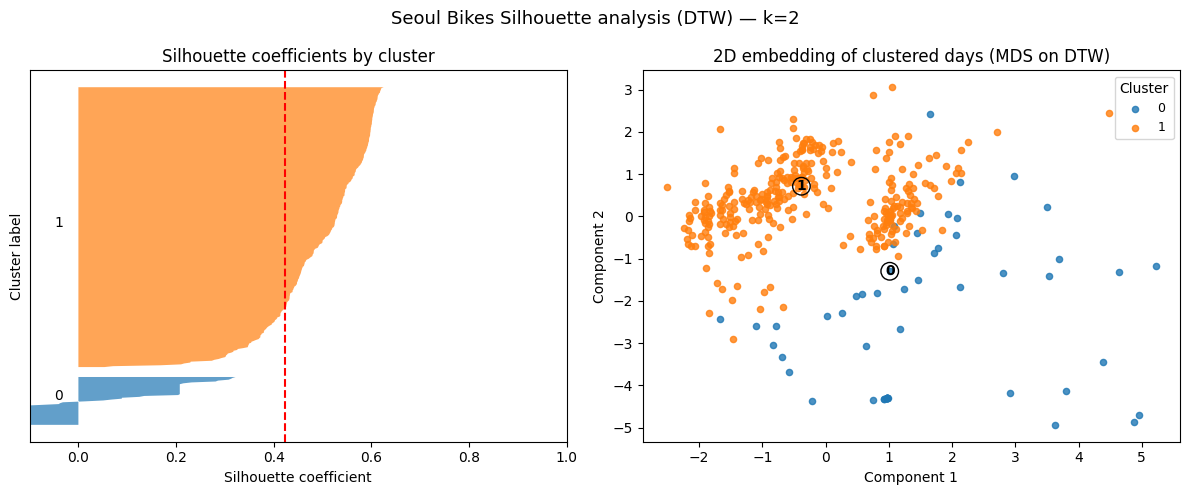

Average silhouette score (k=2): 0.424


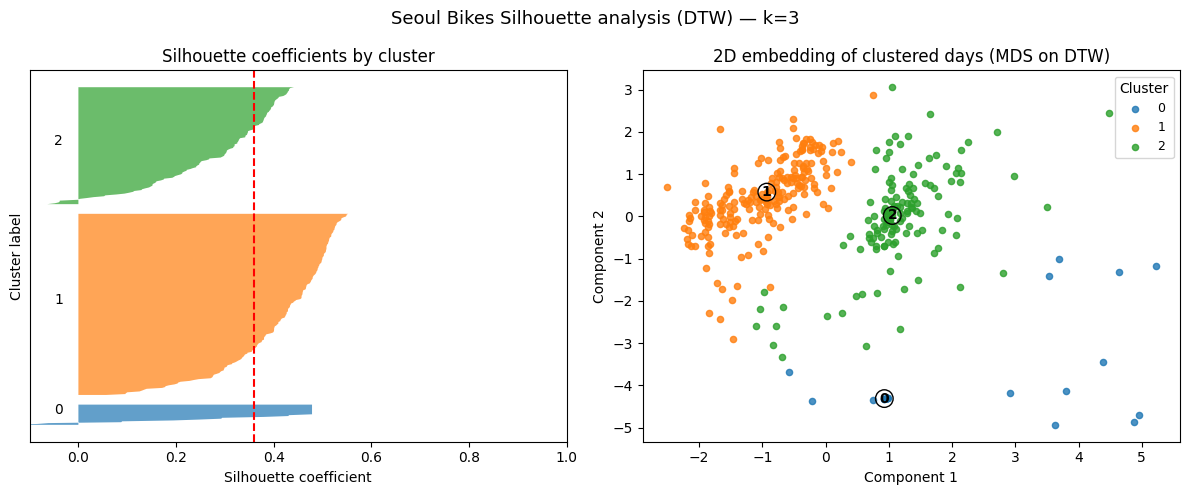

Average silhouette score (k=3): 0.359


np.float64(0.35884052952488354)

In [ ]:
# Visualize Silhouette scores plots
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import MDS

def plot_silhouette_dtw(X_scaled, k, random_state=0, title_prefix=""):
    """
    X_scaled: array of shape (n_samples, n_timestamps, 1)  (e.g., from TimeSeriesScalerMeanVariance)
    k: number of clusters
    """

    # 1) Fit DTW k-means
    model  = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=random_state)
    labels = model.fit_predict(X_scaled)

    # 2) DTW distance matrix + silhouette values
    D = cdist_dtw(X_scaled)  # (n_samples x n_samples)
    sil_avg = silhouette_score(D, labels, metric="precomputed")
    sil_vals = silhouette_samples(D, labels, metric="precomputed")

    # 3) 2-D embedding for visualization (from the DTW distances)
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=random_state)
    coords = mds.fit_transform(D)

    # 4) Make the figure: silhouette (left) + 2D embedding (right)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{title_prefix} Silhouette analysis (DTW) — k={k}", fontsize=13)

    # ---- Left: silhouette plot (classic style)
    y_lower = 10
    for i in range(k):
        cluster_sil = sil_vals[labels == i]
        cluster_sil.sort()
        size_i = cluster_sil.shape[0]
        y_upper = y_lower + size_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10  # 10 for spacing between clusters

    ax1.axvline(x=sil_avg, color="red", linestyle="--")
    ax1.set_title("Silhouette coefficients by cluster")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1.0])
    ax1.set_yticks([])

    # ---- Right: 2D embedding from DTW distances
    for i in range(k):
        ax2.scatter(coords[labels == i, 0], coords[labels == i, 1], s=20, label=f"{i}", alpha=0.8)
    # mark medoid (most central) point per cluster
    for i in range(k):
        idx = np.where(labels == i)[0]
        # medoid = sample with smallest mean DTW distance to others in same cluster
        subD = D[np.ix_(idx, idx)]
        med = idx[np.argmin(subD.mean(axis=1))]
        ax2.scatter(coords[med, 0], coords[med, 1], s=160, marker="o", facecolors='none', edgecolors='k')
        ax2.annotate(f"{i}", (coords[med, 0], coords[med, 1]), ha="center", va="center", fontsize=10, weight="bold")

    ax2.set_title("2D embedding of clustered days (MDS on DTW)")
    ax2.set_xlabel("Component 1")
    ax2.set_ylabel("Component 2")
    ax2.legend(title="Cluster", loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

    print(f"Average silhouette score (k={k}): {sil_avg:.3f}")
    return sil_avg

# ---- How to call (assuming you already built daily_series and X_scaled) ----
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# X_scaled = TimeSeriesScalerMeanVariance().fit_transform(daily_series.values)

plot_silhouette_dtw(X_scaled, k=2, title_prefix="Seoul Bikes")
plot_silhouette_dtw(X_scaled, k=3, title_prefix="Seoul Bikes")



Judging by our Silhouette score visuals, n=3 is the better choice because the 3 clusters would be above the avverage (unlike when n=2, 1 of the clusters is below - even though n=2 has a higher Silhouette score than n=3).

So, in line with the elbow method for choosing the number of clusters, we will move forward with n=3

In [ ]:
# DTW using n=3
n_clusters = 3

model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X_scaled)

In [ ]:
daily_with_labels = daily_series.copy()
daily_with_labels['Cluster'] = labels

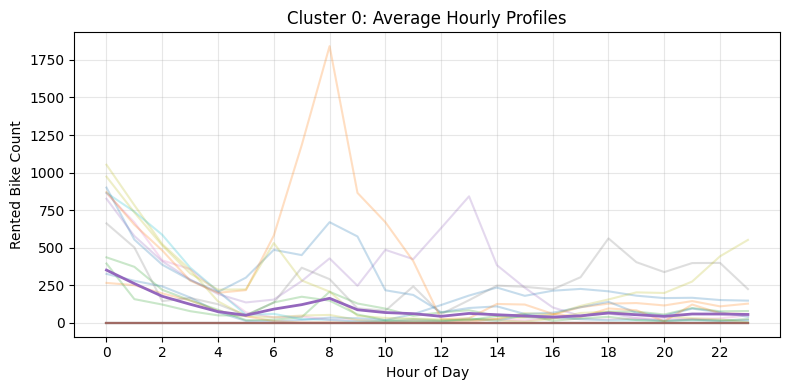

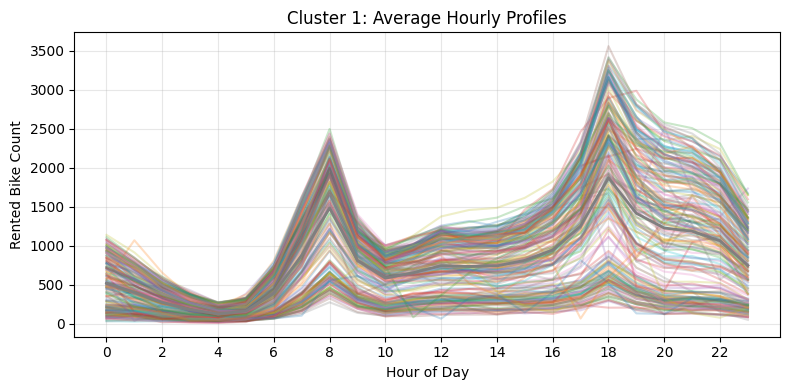

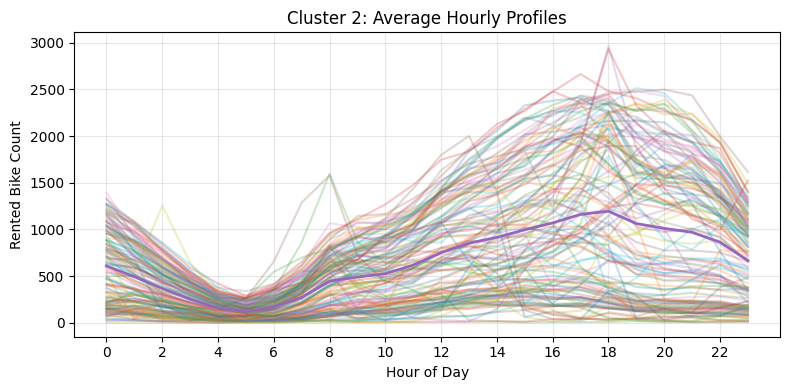

In [ ]:
# Keep only the 24 hour columns for plotting
hour_cols = sorted([
    c for c in daily_series.columns
    if (isinstance(c, (int, np.integer))) or (isinstance(c, str) and c.isdigit())
])
hour_cols = [int(c) for c in hour_cols]   # ensure numeric & sorted
hour_cols = sorted(hour_cols)

n_clusters = len(np.unique(labels))

for cluster in range(n_clusters):
    idx = np.where(labels == cluster)[0]
    plt.figure(figsize=(8,4))
    # plot each day's series in this cluster
    vals = daily_series.iloc[idx][hour_cols].values
    for row in vals:
        plt.plot(hour_cols, row, alpha=0.25)
    # optional: overlay the mean profile
    plt.plot(hour_cols, vals.mean(axis=0), linewidth=2.0)
    plt.title(f'Cluster {cluster}: Average Hourly Profiles')
    plt.xlabel('Hour of Day')
    plt.ylabel('Rented Bike Count')
    plt.xticks(range(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Cluster 0: Low bike usage days

Cluster 1: Regular commuter days (eg. bimodal peaks before and after work)

Cluster 2: Weekend or leisure days

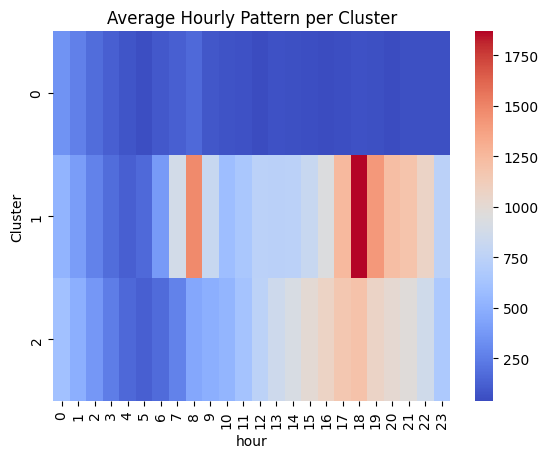

In [ ]:
# Analyze Cluster Characterisitcs
cluster_means = daily_with_labels.groupby('Cluster').mean()
sns.heatmap(cluster_means, cmap='coolwarm')
plt.title("Average Hourly Pattern per Cluster")
plt.show()

## 4.2 Cluster Summary

In [ ]:
# Use renamed columns
# new_columns = ["date","hourly_count","hour","temperature","humidity","wind_speed","visibility", "dew_point_temperature","solar_radiation","rainfall","snowfall","seasons","holiday","functioning_day"]
weather_cols = [c for c in [
    'temperature', 'humidity', 'wind_speed',
    'visibility', 'dew_point_temperature',
    'solar_radiation', 'rainfall', 'snowfall'
] if c in df.columns]

cat_cols = [c for c in ['seasons', 'holiday', 'functioning_day'] if c in df.columns]

# --- Aggregate to daily-level metrics from the long/hourly df ---
# Total rentals per day
by_date = df.groupby('date', as_index=True)
daily_features = pd.DataFrame({
    'total_rentals': by_date['hourly_count'].sum(),
})

# Daily averages for weather (only for those present)
for w in weather_cols:
    daily_features[f'avg_{w}'] = by_date[w].mean()

# Day-of-week info
daily_features['is_weekend'] = daily_features.index.to_series().dt.dayofweek >= 5  # True for Sat/Sun

# Mode for categorical columns (e.g., Season/Holiday). If tie, take first mode.
for c in cat_cols:
    modes = by_date[c].agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
    daily_features[c] = modes

# --- Peak hour & peak value from the wide 24-hour table ---
hour_cols = [col for col in daily_series.columns if isinstance(col, (int, np.integer))]
daily_features['peak_hour']  = daily_series[hour_cols].idxmax(axis=1)
daily_features['peak_value'] = daily_series[hour_cols].max(axis=1)

# --- Attach cluster labels (ensure the index alignment by Date) ---
daily_features = daily_features.join(
    pd.Series(labels, index=daily_series.index, name='Cluster')
)

In [ ]:
# Core Cluster summary table
# Build aggregation dictionary for numeric summaries
agg_dict = {
    'total_rentals': ['size', 'mean', 'median', 'std'],
    'peak_hour':    ['median', (lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)],
    'peak_value':   ['mean', 'median'],
    'is_weekend':   ['mean'],  # proportion of weekend days in each cluster
}

# Add weather means (and optionally std) if present
for w in weather_cols:
    agg_dict[f'avg_{w}'] = ['mean', 'std']

summary = daily_features.groupby('Cluster').agg(agg_dict)

# Tidy column names
summary.columns = [
    '_'.join([lvl for lvl in col if isinstance(lvl, str) and lvl]) for col in summary.columns
]
summary = summary.rename(columns={
    'total_rentals_size':   'n_days',
    'is_weekend_mean':      'weekend_pct',
    'peak_hour_<lambda>':   'peak_hour_mode'
})

# Round for readability
summary = summary.round(2)

print("Cluster Summary (counts, rentals, peak patterns, weather)")
display(summary)


Cluster Summary (counts, rentals, peak patterns, weather)


n_days  total_rentals_mean  total_rentals_median  total_rentals_std  \
Cluster                                                                        
0            24             2263.42                 860.5            2789.48   
1           207            19166.34               21502.0            9627.59   
2           134            16048.95               16062.0            9784.25   

         peak_hour_median  peak_hour_<lambda_0>  peak_value_mean  \
Cluster                                                            
0                     0.0                     0           392.50   
1                    18.0                    18          1914.74   
2                    17.0                    18          1410.57   

         peak_value_median  weekend_pct  avg_temperature_mean  ...  \
Cluster                                                        ...   
0                    133.0         0.29                 15.69  ...   
1                   2100.0         0.00                 12.30  ...   
2                   1494.5         0.72                 13.28  ...   

         avg_wind_speed_mean  avg_wind_speed_std  avg_visibility_mean  \
Cluster                                                                 
0                       1.61                0.63              1250.41   
1                       1.76                0.59              1469.71   
2                       1.70                0.61              1419.41   

         avg_visibility_std  avg_dew_point_temperature_mean  \
Cluster                                                       
0                    557.02                            9.77   
1                    481.69                            3.02   
2                    489.06                            4.68   

         avg_dew_point_temperature_std  avg_solar_radiation_mean  \
Cluster                                                            
0                                 6.83                      0.36   
1                                13.45                      0.60   
2                                12.36                      0.56   

         avg_solar_radiation_std  avg_rainfall_mean  avg_rainfall_std  
Cluster                                                                
0                           0.32               0.83              1.19  
1                           0.30               0.04              0.14  
2                           0.32               0.20              0.54  

[3 rows x 23 columns]

Cluster 0: Low bike usage days

Cluster 1: Regular commuter days (Weekdays)

Cluster 2: Weekends and leisure days

In [ ]:
# Season composition per cluster (row-normalized %)
if 'seasons' in daily_features.columns:
    season_counts = (daily_features
                     .pivot_table(index='Cluster', columns='seasons', aggfunc='size', fill_value=0))
    season_pct = season_counts.div(season_counts.sum(axis=1), axis=0).round(3)
    print("Season Distribution by Cluster (row %)**")
    display(season_pct)

# Holiday composition per cluster (if available)
if 'holiday' in daily_features.columns:
    holiday_counts = (daily_features
                      .pivot_table(index='Cluster', columns='holiday', aggfunc='size', fill_value=0))
    holiday_pct = holiday_counts.div(holiday_counts.sum(axis=1), axis=0).round(3)
    print("Holiday Distribution by Cluster (row %)**")
    display(holiday_pct)

Season Distribution by Cluster (row %)**


seasons  Autumn  Spring  Summer  Winter
Cluster                                
0         0.500   0.250   0.167   0.083
1         0.232   0.246   0.256   0.266
2         0.231   0.261   0.261   0.246

Holiday Distribution by Cluster (row %)**


holiday  holiday  non_holiday
Cluster                      
0          0.083        0.917
1          0.005        0.995
2          0.112        0.888

Cluster 0 low usage days: They mostly occured in autumn, then spring, follwoed by summer and not much in winter. Low usage days were mostly not holidays.

Cluster 1 weekday pattern: Very even spread of bike usage over all seasons. Almost all days were not holidays.

Cluster 2 weekend/leisure day pattern: Very even spread over all seasons. More holiday days than the other clusters.

In [ ]:
# Average hourly profile per cluster
avg_hourly_by_cluster = (
    daily_series[hour_cols]
    .assign(Cluster=daily_features['Cluster'])
    .groupby('Cluster')[hour_cols]
    .mean()
    .round(1)
)

print("Average Hourly Profile per Cluster")
display(avg_hourly_by_cluster)

Average Hourly Profile per Cluster


hour        0      1      2      3      4      5      6      7       8   \
Cluster                                                                   
0        351.4  261.5  176.9  124.0   74.6   51.0   91.7  121.3   163.6   
1        519.5  401.4  273.3  180.5  123.1  161.8  386.3  876.9  1482.4   
2        609.4  494.0  367.8  252.8  157.6  119.7  170.1  274.4   447.4   

hour        9   ...     14     15      16      17      18      19      20  \
Cluster         ...                                                         
0         87.2  ...   54.2   46.1    38.6    47.0    66.0    54.2    43.5   
1        811.0  ...  739.4  811.3   943.6  1250.3  1868.6  1413.1  1224.8   
2        491.1  ...  915.1  997.0  1070.4  1161.4  1195.5  1062.8  1011.9   

hour         21      22     23  
Cluster                         
0          59.2    58.8   56.0  
1        1184.2  1061.1  745.1  
2         969.6   864.0  666.9  

[3 rows x 24 columns]

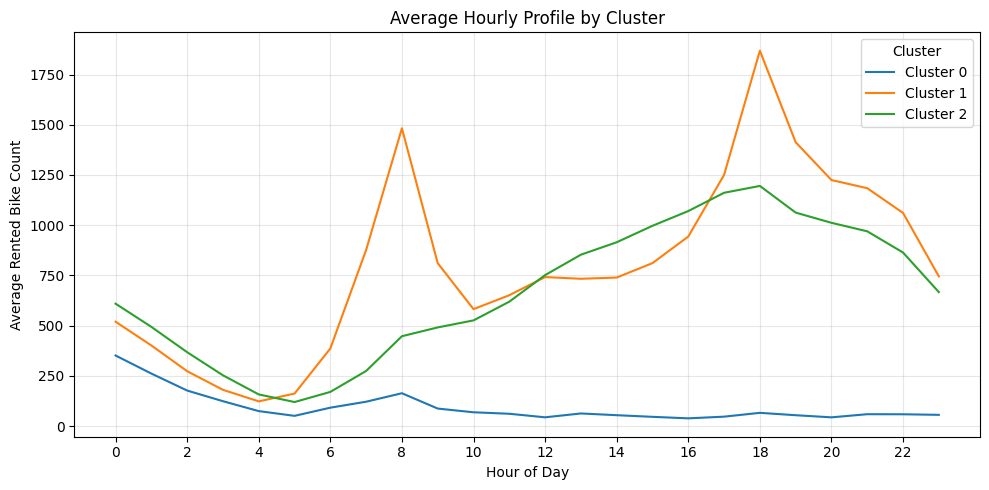

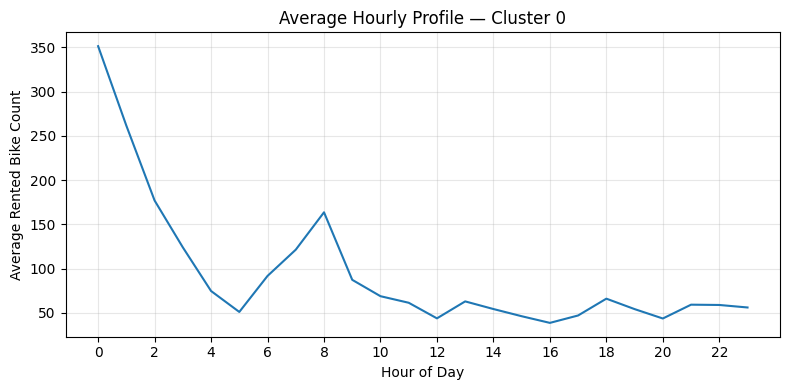

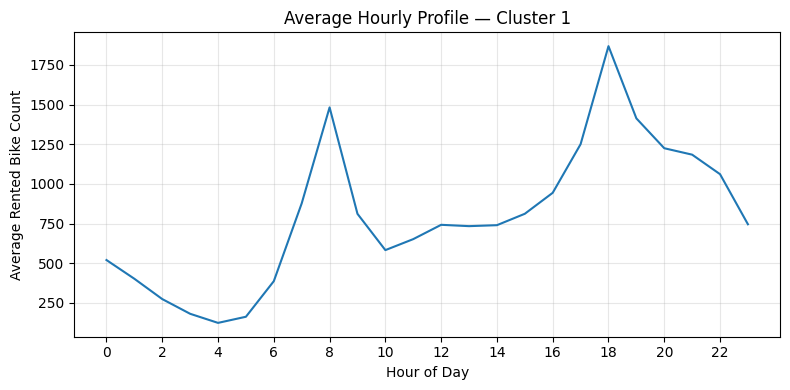

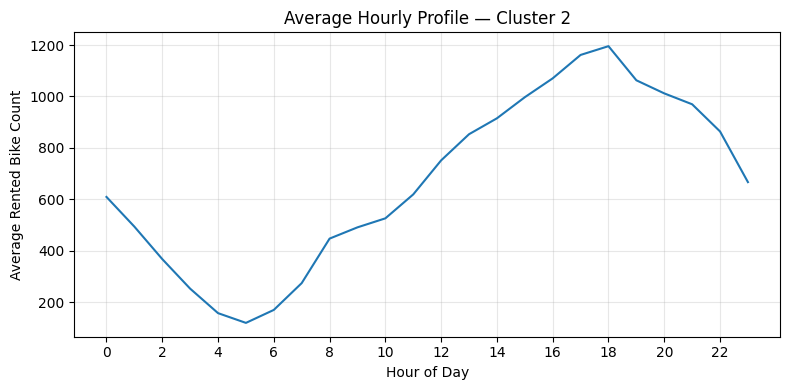

In [ ]:
# Plotting

# Compute the average 24-hour profile per cluster
hour_cols = [c for c in daily_series.columns if isinstance(c, (int, np.integer))]
hour_cols = sorted(hour_cols)  # ensure 0..23 order

avg_hourly_by_cluster = (
    daily_series[hour_cols]
    .assign(Cluster=daily_features['Cluster'])
    .groupby('Cluster')[hour_cols]
    .mean()
)

# All clusters on one chart
plt.figure(figsize=(10,5))
for cluster, row in avg_hourly_by_cluster.iterrows():
    plt.plot(hour_cols, row.values, label=f'Cluster {int(cluster)}')
plt.title('Average Hourly Profile by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rented Bike Count')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# One chart per cluster
for cluster, row in avg_hourly_by_cluster.iterrows():
    plt.figure(figsize=(8,4))
    plt.plot(hour_cols, row.values)
    plt.title(f'Average Hourly Profile — Cluster {int(cluster)}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Rented Bike Count')
    plt.xticks(range(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

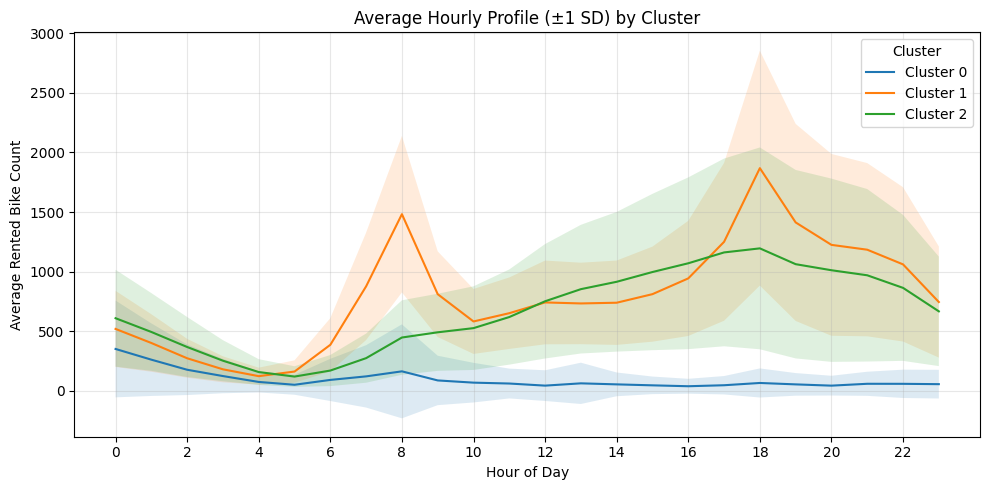

In [ ]:
# Showing variability by adding standard deviation bands
std_hourly_by_cluster = (
    daily_series[hour_cols]
    .assign(Cluster=daily_features['Cluster'])
    .groupby('Cluster')[hour_cols]
    .std()
)

plt.figure(figsize=(10,5))
for cluster in avg_hourly_by_cluster.index:
    mean_vals = avg_hourly_by_cluster.loc[cluster].values
    std_vals  = std_hourly_by_cluster.loc[cluster].values
    plt.plot(hour_cols, mean_vals, label=f'Cluster {int(cluster)}')
    plt.fill_between(hour_cols, mean_vals-std_vals, mean_vals+std_vals, alpha=0.15)
plt.title('Average Hourly Profile (±1 SD) by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rented Bike Count')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## 4.3 Anomoly Detection

In [ ]:
# Analomous days that do not fit well in any cluster
# They have large distance from their cluster centroid

# Compute distance of each day to its cluster centroid
centroids = model.cluster_centers_
distances = np.array([
    dtw(X_scaled[i].ravel(), centroids[labels[i]].ravel())
    for i in range(len(X_scaled))
])

# Flag anomalies: ie. the days whose DTW distance > 95th percentile
threshold = np.percentile(distances, 95)
anomalies = np.where(distances > threshold)[0]

print(f"{len(anomalies)} anomalous days detected (>{threshold:.2f} DTW distance)")
print("Example anomaly dates:", daily_series.index[anomalies][:10].tolist())


19 anomalous days detected (>2.60 DTW distance)
Example anomaly dates: [Timestamp('2018-02-28 00:00:00'), Timestamp('2018-04-23 00:00:00'), Timestamp('2018-05-02 00:00:00'), Timestamp('2018-05-12 00:00:00'), Timestamp('2018-05-16 00:00:00'), Timestamp('2018-05-17 00:00:00'), Timestamp('2018-05-22 00:00:00'), Timestamp('2018-06-26 00:00:00'), Timestamp('2018-06-28 00:00:00'), Timestamp('2018-06-30 00:00:00')]


19 anomalous days from the whole dataset were detected.

These days could be holidays, special events, extreme weather, non-functioning days, etc.

In [ ]:
# Hourly point anomolies
# Z-score for each hour across all days
z_scores = ((df['hourly_count'] - df['hourly_count'].mean()) /
             df['hourly_count'].std())

# Flag hours where z-score exceeds threshold (e.g. 3 std deviations)
anomalies_hourly = df[np.abs(z_scores) > 3]

print("Extreme hourly outliers:")
print(anomalies_hourly[['date', 'hour', 'hourly_count']].head())


Extreme hourly outliers:
           date  hour  hourly_count
3282 2018-04-16    18          2692
3498 2018-04-25    18          2807
3714 2018-05-04    18          2661
3834 2018-05-09    18          3130
3882 2018-05-11    18          2701


In [ ]:
# Outliers from any day of the dataset
# Weekday anomolies
# Add weekday column
df['weekday'] = df['date'].dt.day_name()

# 1) weekday stats
weekday_stats = (
    df.groupby('weekday', as_index=False)
      .agg(mean_wd=('hourly_count', 'mean'),
           std_wd =('hourly_count', 'std'))
)

# 2) merge back
df = df.merge(weekday_stats, on='weekday', how='left')

# 3) safe z-score (avoid divide-by-zero)
eps = 1e-9
df['weekday_z'] = (df['hourly_count'] - df['mean_wd']) / (df['std_wd'].replace(0, eps))

# 4) flag anomalies (>|3| SD)
anomalies_weekday = df[df['weekday_z'].abs() > 3]

print("Weekday-based outliers:")
print(anomalies_weekday[['date','hour','weekday','hourly_count','weekday_z']].head())

Weekday-based outliers:
           date  hour    weekday  hourly_count  weekday_z
3498 2018-04-25    18  Wednesday          2807   3.050075
3834 2018-05-09    18  Wednesday          3130   3.526776
3954 2018-05-14    18     Monday          2906   3.271526
3978 2018-05-15    18    Tuesday          2915   3.414811
4122 2018-05-21    18     Monday          3069   3.516653


In [ ]:
# Seasonal anomolies
season_stats = (
    df.groupby('seasons')['hourly_count']
      .agg(['mean', 'std'])
      .rename(columns={'mean': 'mean_season', 'std': 'std_season'})
)

df = df.merge(season_stats, on='seasons', how='left')
df['season_z'] = (df['hourly_count'] - df['mean_season']) / df['std_season']

anomalies_season = df[np.abs(df['season_z']) > 3]
print(anomalies_season[['date', 'hour', 'seasons', 'hourly_count', 'season_z']].head())


          date  hour seasons  hourly_count  season_z
8   2017-12-01     8  Winter           930  4.684766
18  2017-12-01    18  Winter           862  4.232555
80  2017-12-04     8  Winter           937  4.731318
90  2017-12-04    18  Winter           807  3.866796
104 2017-12-05     8  Winter           812  3.900047


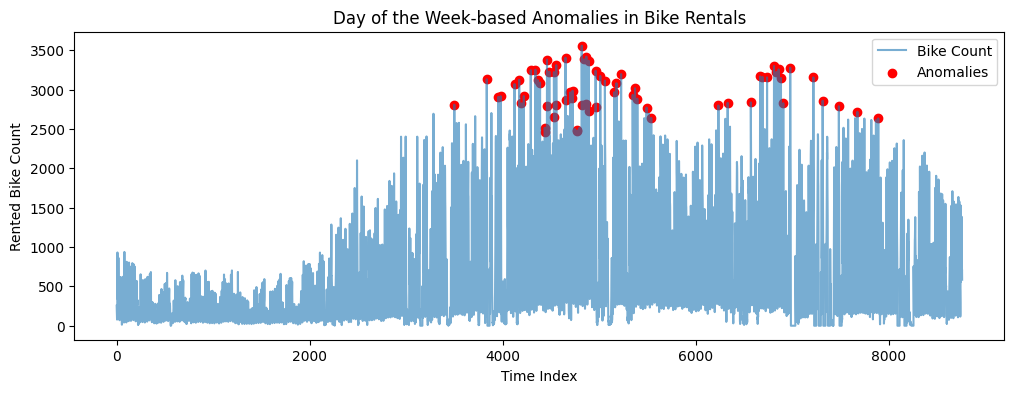

In [ ]:
# Visualize day of the week anomoly

plt.figure(figsize=(12,4))
plt.plot(df['hourly_count'], label='Bike Count', alpha=0.6)
plt.scatter(anomalies_weekday.index,
            anomalies_weekday['hourly_count'],
            color='red', label='Anomalies')
plt.title('Day of the Week-based Anomalies in Bike Rentals')
plt.xlabel('Time Index')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()


/tmp/ipython-input-3334029498.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=weekdays_order, showfliers=False)


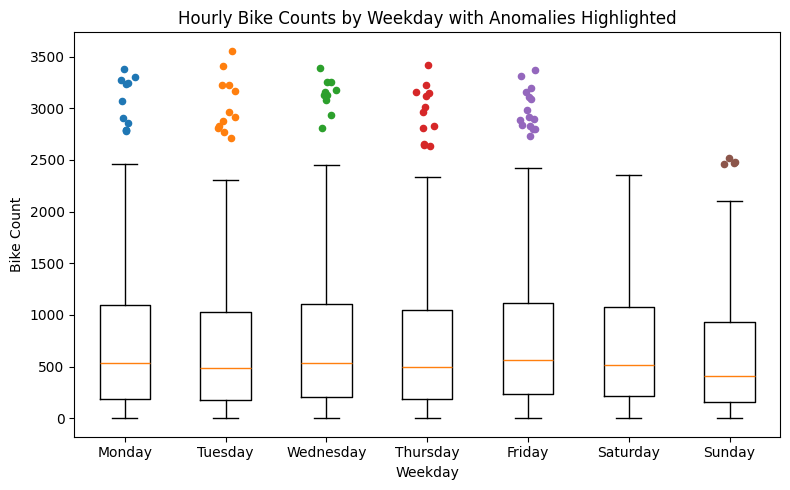

In [ ]:
# day of the week anomolies

plt.figure(figsize=(8,5))
weekdays_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
data = [df.loc[df['weekday']==w, 'hourly_count'] for w in weekdays_order]

plt.boxplot(data, labels=weekdays_order, showfliers=False)
# Flag anomalies: ie. the days whose DTW distance > 95th percentile
df['is_anom'] = df.index.isin(anomalies_weekday.index)
for i, w in enumerate(weekdays_order, start=1):
    y = df.loc[(df['weekday']==w) & (df['is_anom']), 'hourly_count']
    if len(y) > 0:
        x = np.random.normal(i, 0.05, len(y))
        plt.scatter(x, y, s=20)
plt.title('Hourly Bike Counts by Weekday with Anomalies Highlighted')
plt.xlabel('Weekday')
plt.ylabel('Bike Count')
plt.tight_layout()
plt.show()

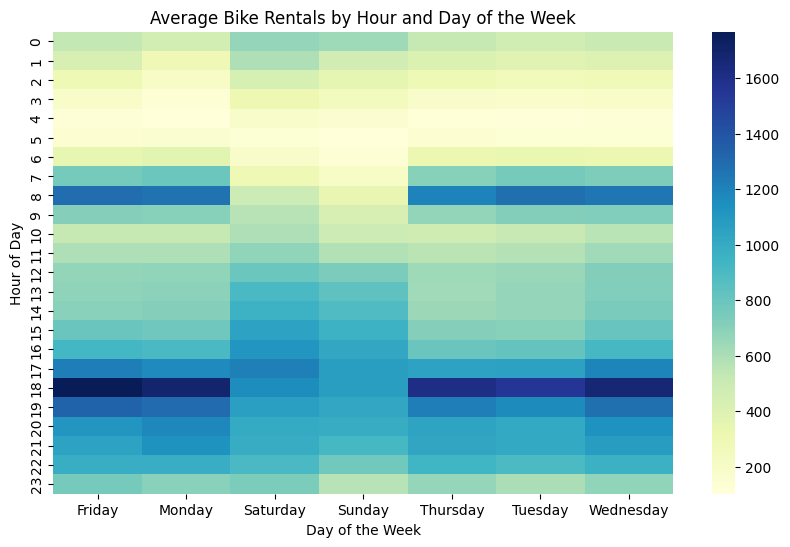

In [ ]:
# heatmap of hour and day of week

pivot = df.pivot_table(index='hour', columns='weekday',
                       values='hourly_count', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Average Bike Rentals by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of Day')
plt.show()


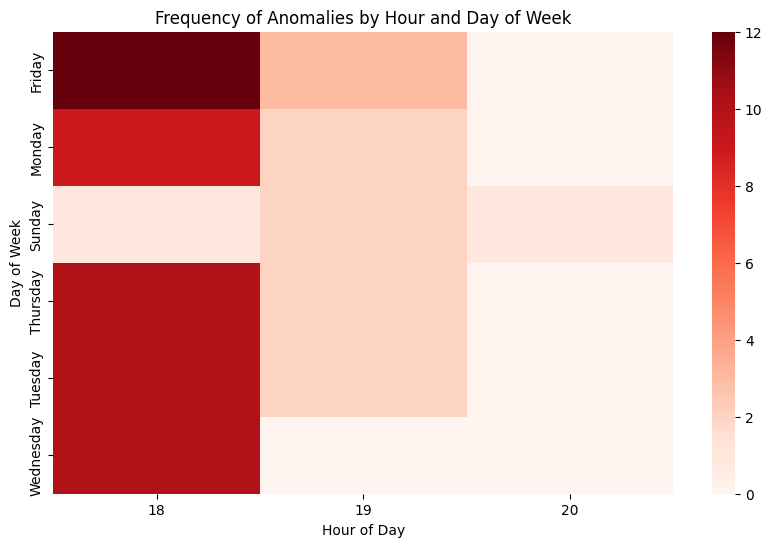

In [ ]:
# anomoly heatmap
anom_heatmap = (
    df[df['is_anom']]
      .groupby(['weekday','hour']).size()
      .unstack(fill_value=0)
)

plt.figure(figsize=(10,6))
sns.heatmap(anom_heatmap, cmap='Reds')
plt.title('Frequency of Anomalies by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


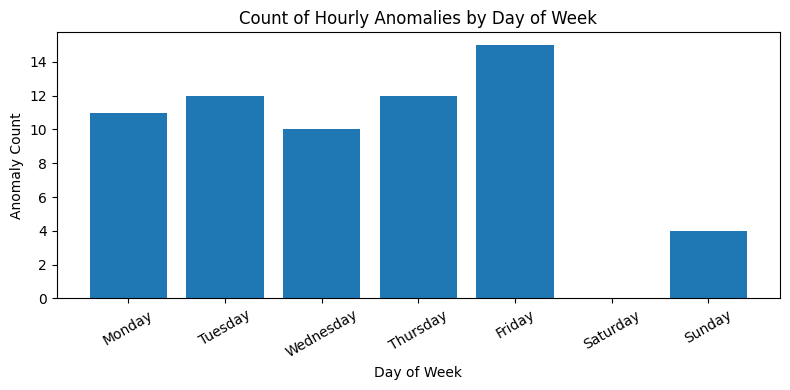

In [ ]:
# barchart of anomolies per day of week
anom_counts = df[df['is_anom']].groupby('weekday').size().reindex(weekdays_order, fill_value=0)
plt.figure(figsize=(8,4))
plt.bar(anom_counts.index, anom_counts.values)
plt.title('Count of Hourly Anomalies by Day of Week')
plt.ylabel('Anomaly Count')
plt.xlabel('Day of Week')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize Seasonal anomolies
DATE_COL   = 'date'
SEASON_COL = 'seasons'
HOUR_COL   = 'hour'
COUNT_COL  = 'hourly_count'
Z_THRESH   = 3.0  # anomaly threshold in SD units


df = df.copy()
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')

In [ ]:
# season order for nicer plots
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
if set(season_order).issuperset(set(df[SEASON_COL].unique())):
    df[SEASON_COL] = pd.Categorical(df[SEASON_COL], categories=season_order, ordered=True)

In [ ]:
# Compute per-season mean and std of bike counts
season_stats = (
    df.groupby(SEASON_COL)[COUNT_COL]
      .agg(['mean', 'std'])
      .rename(columns={'mean': 'mean_season', 'std': 'std_season'})
      .reset_index()
)

# Merge back into df
df = df.merge(season_stats, on=SEASON_COL, how='left')

# Compute z-score for each observation within its season
eps = 1e-9  # avoid divide-by-zero
df['season_z'] = (df[COUNT_COL] - df['mean_season']) / (df['std_season'].replace(0, eps))

# Flag anomalies
Z_THRESH = 3
df['is_anom'] = df['season_z'].abs() > Z_THRESH

/tmp/ipython-input-3224489727.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(SEASON_COL)[COUNT_COL]


In [ ]:
season_stats = (
    df.groupby(SEASON_COL, as_index=False)
      .agg(mean_season=(COUNT_COL, 'mean'),
           std_season =(COUNT_COL, 'std'))
)

/tmp/ipython-input-4096594560.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(SEASON_COL, as_index=False)


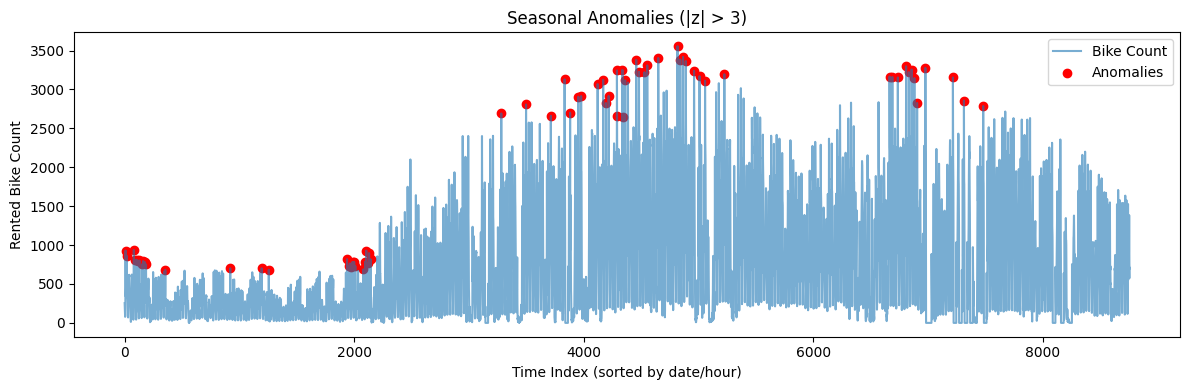

In [ ]:
# Sort by date/hour for continuous time series
df_sorted = df.sort_values([DATE_COL, HOUR_COL])

plt.figure(figsize=(12,4))
plt.plot(df_sorted.index, df_sorted[COUNT_COL].values, label='Bike Count', alpha=0.6)
anom_idx = df_sorted.index[df_sorted['is_anom']]
plt.scatter(anom_idx, df_sorted.loc[anom_idx, COUNT_COL].values, color='red', label='Anomalies')
plt.title(f'Seasonal Anomalies (|z| > {Z_THRESH})')
plt.xlabel('Time Index (sorted by date/hour)')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-2127672455.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_by_season, labels=season_labels, showfliers=False)


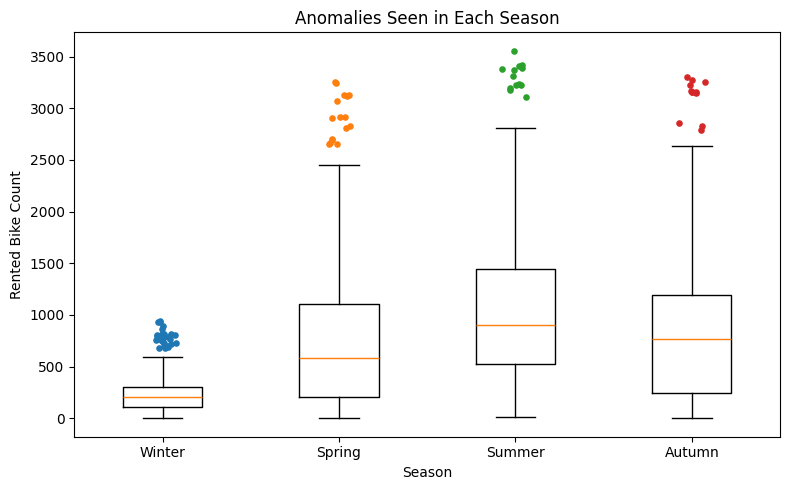

In [ ]:
# boxplot of anomolies per season
# Prepare data in season order
season_labels = [s for s in season_order if s in df[SEASON_COL].unique().tolist()]
data_by_season = [df.loc[df[SEASON_COL]==s, COUNT_COL].values for s in season_labels]

plt.figure(figsize=(8, 5))
bp = plt.boxplot(data_by_season, labels=season_labels, showfliers=False)
# Overlay anomaly points with slight horizontal jitter
x_positions = []
for i, s in enumerate(season_labels, start=1):
    y = df.loc[(df[SEASON_COL]==s) & (df['is_anom']), COUNT_COL].values
    if len(y) > 0:
        x = np.random.normal(loc=i, scale=0.04, size=len(y))
        plt.scatter(x, y, s=14)  # anomalies
plt.title('Anomalies Seen in Each Season')
plt.xlabel('Season')
plt.ylabel('Rented Bike Count')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1773681159.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(SEASON_COL)[COUNT_COL].size()


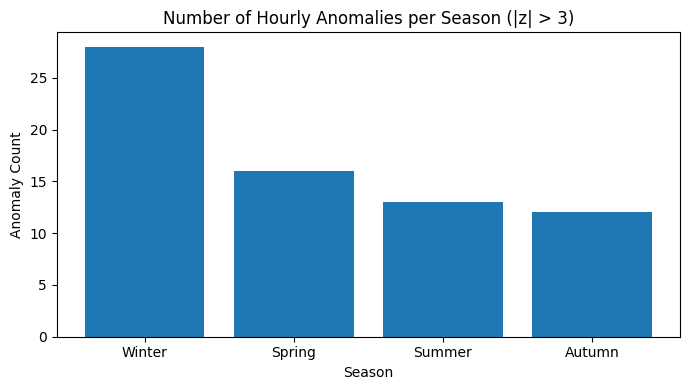

In [ ]:
# Barchart of anomolies
anom_counts = (df.loc[df['is_anom']]
               .groupby(SEASON_COL)[COUNT_COL].size()
               .reindex(season_labels, fill_value=0))

plt.figure(figsize=(7, 4))
plt.bar(anom_counts.index.astype(str), anom_counts.values)
plt.title(f'Number of Hourly Anomalies per Season (|z| > {Z_THRESH})')
plt.xlabel('Season')
plt.ylabel('Anomaly Count')
plt.tight_layout()
plt.show()

In [ ]:
# top 10 anomolies by season
top = (df.loc[df['is_anom'], [DATE_COL, HOUR_COL, SEASON_COL, COUNT_COL, 'season_z']]
         .sort_values('season_z', key=lambda s: s.abs(), ascending=False)
         .head(10))
print("Top 10 seasonal anomalies by |z|:\n", top)

Top 10 seasonal anomalies by |z|:
            date  hour seasons  hourly_count  season_z
80   2017-12-04     8  Winter           937  4.731318
8    2017-12-01     8  Winter           930  4.684766
2106 2018-02-26    18  Winter           929  4.678116
2130 2018-02-27    18  Winter           897  4.465311
18   2017-12-01    18  Winter           862  4.232555
4338 2018-05-30    18  Spring          3251  4.056202
4290 2018-05-28    18  Spring          3245  4.046548
1938 2018-02-19    18  Winter           819  3.946598
2144 2018-02-28     8  Winter           816  3.926648
104  2017-12-05     8  Winter           812  3.900047


# 5.Feature Engineering


In [ ]:
df['seasons'] = df['seasons'].astype('object')
df['holiday'] = df['holiday'].astype('object')
df['weekday'] = df['weekday'].astype('object')
df['hour'] = df['hour'].astype('object')

In [ ]:
df.columns

Index(['date', 'hourly_count', 'hour', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temperature', 'solar_radiation', 'rainfall',
       'sonwfall', 'seasons', 'holiday', 'functioning_day', 'daily_count_x',
       'hourly_ratio', 'month', 'weekday', 'daily_count_y', 'daily_count',
       'mean_wd', 'std_wd', 'weekday_z', 'mean_season_x', 'std_season_x',
       'season_z', 'is_anom', 'mean_season_y', 'std_season_y', 'mean_season',
       'std_season'],
      dtype='object')

In [ ]:
# Separate numerical and categorical columns.
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['hourly_count', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temperature', 'solar_radiation', 'rainfall', 'sonwfall', 'daily_count_x', 'hourly_ratio', 'daily_count_y', 'daily_count', 'mean_wd', 'std_wd', 'weekday_z', 'mean_season_x', 'std_season_x', 'season_z', 'mean_season_y', 'std_season_y', 'mean_season', 'std_season']
Categorical Features: ['hour', 'seasons', 'holiday', 'functioning_day', 'month', 'weekday']


In [ ]:
# Convert categorical columns into dummy variables using one-hot encoding.
df_categorical = df[categorical_features]
df_dummies = pd.get_dummies(df_categorical)

df_dummies = df_dummies.replace({False: 0, True: 1})
df_dummies['date'] = df['date']
df_dummies['hour'] = df['hour']
display(df_dummies.head())

/tmp/ipython-input-1988603043.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies = df_dummies.replace({False: 0, True: 1})


hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  \
0       1       0       0       0       0       0       0       0       0   
1       0       1       0       0       0       0       0       0       0   
2       0       0       1       0       0       0       0       0       0   
3       0       0       0       1       0       0       0       0       0   
4       0       0       0       0       1       0       0       0       0   

   hour_9  ...  month_Sep  weekday_Friday  weekday_Monday  weekday_Saturday  \
0       0  ...          0               1               0                 0   
1       0  ...          0               1               0                 0   
2       0  ...          0               1               0                 0   
3       0  ...          0               1               0                 0   
4       0  ...          0               1               0                 0   

   weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0               0                 0                0                  0   
1               0                 0                0                  0   
2               0                 0                0                  0   
3               0                 0                0                  0   
4               0                 0                0                  0   

        date  hour  
0 2017-12-01     0  
1 2017-12-01     1  
2 2017-12-01     2  
3 2017-12-01     3  
4 2017-12-01     4  

[5 rows x 53 columns]

In [ ]:
# Generating Polars-engineered lagged features
# https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html
pl_df = pl.from_pandas(df)
lagged_pl_df = pl_df.select(
    "hourly_count",
    *[pl.col("hourly_count").shift(i).alias(f"lagged_hourly_count_{i}h") for i in range(1,13)],
    # *[pl.col("daily_count").shift(i).alias(f"lagged_daily_count_{i}h") for i in range(1,8)],
    lagged_mean_24h=pl.col("hourly_count").shift(1).rolling_mean(24),
    lagged_max_24h=pl.col("hourly_count").shift(1).rolling_max(24),
    lagged_min_24h=pl.col("hourly_count").shift(1).rolling_min(24),
    lagged_mean_2d=pl.col("hourly_count").shift(1).rolling_mean(2 * 24),
    lagged_max_2d=pl.col("hourly_count").shift(1).rolling_max(2 * 24),
    lagged_min_2d=pl.col("hourly_count").shift(1).rolling_min(2 * 24),
    lagged_mean_3d=pl.col("hourly_count").shift(1).rolling_mean(3 * 24),
    lagged_max_3d=pl.col("hourly_count").shift(1).rolling_max(3 * 24),
    lagged_min_3d=pl.col("hourly_count").shift(1).rolling_min(3 * 24),
    lagged_mean_4d=pl.col("hourly_count").shift(1).rolling_mean(4 * 24),
    lagged_max_4d=pl.col("hourly_count").shift(1).rolling_max(4 * 24),
    lagged_min_4d=pl.col("hourly_count").shift(1).rolling_min(4 * 24),
    lagged_mean_5d=pl.col("hourly_count").shift(1).rolling_mean(5 * 24),
    lagged_max_5d=pl.col("hourly_count").shift(1).rolling_max(5 * 24),
    lagged_min_5d=pl.col("hourly_count").shift(1).rolling_min(5 * 24),
    lagged_mean_6d=pl.col("hourly_count").shift(1).rolling_mean(6 * 24),
    lagged_max_6d=pl.col("hourly_count").shift(1).rolling_max(6 * 24),
    lagged_min_6d=pl.col("hourly_count").shift(1).rolling_min(6 * 24),
    lagged_mean_7d=pl.col("hourly_count").shift(1).rolling_mean(7 * 24),
    lagged_max_7d=pl.col("hourly_count").shift(1).rolling_max(7 * 24),
    lagged_min_7d=pl.col("hourly_count").shift(1).rolling_min(7 * 24),
)
lagged_pl_df.tail(10)

shape: (10, 34)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hourly_co ┆ lagged_ho ┆ lagged_ho ┆ lagged_ho ┆ … ┆ lagged_mi ┆ lagged_me ┆ lagged_ma ┆ lagged_m │
│ unt       ┆ urly_coun ┆ urly_coun ┆ urly_coun ┆   ┆ n_6d      ┆ an_7d     ┆ x_7d      ┆ in_7d    │
│ ---       ┆ t_1h      ┆ t_2h      ┆ t_3h      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ i64       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ i64       ┆ f64       ┆ i64       ┆ i64      │
│           ┆ i64       ┆ i64       ┆ i64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 761       ┆ 740       ┆ 720       ┆ 642       ┆ … ┆ 75        ┆ 598.59523 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 8         ┆           ┆          │
│ 768       ┆ 761       ┆ 740       ┆ 720       ┆ … ┆ 75        ┆ 598.84523 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 8         ┆           ┆          │
│ 837       ┆ 768       ┆ 761       ┆ 740       ┆ … ┆ 75        ┆ 598.94047 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 6         ┆           ┆          │
│ 1047      ┆ 837       ┆ 768       ┆ 761       ┆ … ┆ 75        ┆ 598.61904 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 8         ┆           ┆          │
│ 1384      ┆ 1047      ┆ 837       ┆ 768       ┆ … ┆ 75        ┆ 598.29761 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 9         ┆           ┆          │
│ 1003      ┆ 1384      ┆ 1047      ┆ 837       ┆ … ┆ 75        ┆ 597.32142 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 9         ┆           ┆          │
│ 764       ┆ 1003      ┆ 1384      ┆ 1047      ┆ … ┆ 75        ┆ 597.29761 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 9         ┆           ┆          │
│ 694       ┆ 764       ┆ 1003      ┆ 1384      ┆ … ┆ 75        ┆ 597.27976 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 2         ┆           ┆          │
│ 712       ┆ 694       ┆ 764       ┆ 1003      ┆ … ┆ 75        ┆ 597.36904 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 8         ┆           ┆          │
│ 584       ┆ 712       ┆ 694       ┆ 764       ┆ … ┆ 75        ┆ 597.26785 ┆ 1708      ┆ 24       │
│           ┆           ┆           ┆           ┆   ┆           ┆ 7         ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [ ]:
# Convert lagged_pl_df to pandas DataFrame
lagged_df = lagged_pl_df.drop('hourly_count').to_pandas()

# Merge df and df_dummies
df_combined = pd.merge(df, df_dummies, on=['date', 'hour'], how='left')
df_combined.drop(categorical_features, axis=1, inplace=True)
df_combined.head()

# Merge df_combined with lagged_df
df_merged = pd.concat([df_combined, lagged_df], axis=1)
df_merged['hour'] = df['hour'].astype(int)
display(df_merged.head())
display(df_merged.tail())

date  hourly_count  temperature  humidity  wind_speed  visibility  \
0 2017-12-01           254         -5.2        37         2.2        2000   
1 2017-12-01           204         -5.5        38         0.8        2000   
2 2017-12-01           173         -6.0        39         1.0        2000   
3 2017-12-01           107         -6.2        40         0.9        2000   
4 2017-12-01            78         -6.0        36         2.3        2000   

   dew_point_temperature  solar_radiation  rainfall  sonwfall  ...  \
0                  -17.6              0.0       0.0       0.0  ...   
1                  -17.6              0.0       0.0       0.0  ...   
2                  -17.7              0.0       0.0       0.0  ...   
3                  -17.6              0.0       0.0       0.0  ...   
4                  -18.6              0.0       0.0       0.0  ...   

   lagged_mean_5d  lagged_max_5d  lagged_min_5d  lagged_mean_6d  \
0             NaN            NaN            NaN             NaN   
1             NaN            NaN            NaN             NaN   
2             NaN            NaN            NaN             NaN   
3             NaN            NaN            NaN             NaN   
4             NaN            NaN            NaN             NaN   

   lagged_max_6d  lagged_min_6d  lagged_mean_7d  lagged_max_7d  lagged_min_7d  \
0            NaN            NaN             NaN            NaN            NaN   
1            NaN            NaN             NaN            NaN            NaN   
2            NaN            NaN             NaN            NaN            NaN   
3            NaN            NaN             NaN            NaN            NaN   
4            NaN            NaN             NaN            NaN            NaN   

   hour  
0     0  
1     1  
2     2  
3     3  
4     4  

[5 rows x 110 columns]

date  hourly_count  temperature  humidity  wind_speed  visibility  \
8755 2018-11-30          1003          4.2        34         2.6        1894   
8756 2018-11-30           764          3.4        37         2.3        2000   
8757 2018-11-30           694          2.6        39         0.3        1968   
8758 2018-11-30           712          2.1        41         1.0        1859   
8759 2018-11-30           584          1.9        43         1.3        1909   

      dew_point_temperature  solar_radiation  rainfall  sonwfall  ...  \
8755                  -10.3              0.0       0.0       0.0  ...   
8756                   -9.9              0.0       0.0       0.0  ...   
8757                   -9.9              0.0       0.0       0.0  ...   
8758                   -9.8              0.0       0.0       0.0  ...   
8759                   -9.3              0.0       0.0       0.0  ...   

      lagged_mean_5d  lagged_max_5d  lagged_min_5d  lagged_mean_6d  \
8755      679.483333         1708.0           95.0      639.486111   
8756      682.708333         1708.0           95.0      643.534722   
8757      684.325000         1708.0           95.0      646.416667   
8758      685.558333         1708.0           95.0      648.513889   
8759      687.358333         1708.0           95.0      650.708333   

      lagged_max_6d  lagged_min_6d  lagged_mean_7d  lagged_max_7d  \
8755         1708.0           75.0      597.321429         1708.0   
8756         1708.0           75.0      597.297619         1708.0   
8757         1708.0           75.0      597.279762         1708.0   
8758         1708.0           75.0      597.369048         1708.0   
8759         1708.0           75.0      597.267857         1708.0   

      lagged_min_7d  hour  
8755           24.0    19  
8756           24.0    20  
8757           24.0    21  
8758           24.0    22  
8759           24.0    23  

[5 rows x 110 columns]

## Split the data into training and test data

In [ ]:
# Combine date and hour into a single datetime index
df_merged['datetime'] = pd.to_datetime(df_merged['date'].astype(str) + ' ' + df_merged['hour'].astype(str) + ':00:00')
df_merged.set_index('datetime', inplace=True)

# Drop the original 'date' and 'hour' columns
drop_list = ['is_anom','date', 'hour','daily_count_x', 'hourly_ratio', 'daily_count_y', 'daily_count', 'mean_wd', 'std_wd', 'weekday_z', 'mean_season_x', 'std_season_x', 'season_z', 'mean_season_y', 'std_season_y', 'mean_season', 'std_season']
df_merged.drop(drop_list, axis=1, inplace=True)
df_merged.dropna(inplace=True)

In [ ]:
df_merged.columns

Index(['hourly_count', 'temperature', 'humidity', 'wind_speed', 'visibility',
       'dew_point_temperature', 'solar_radiation', 'rainfall', 'sonwfall',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'seasons_Autumn',
       'seasons_Spring', 'seasons_Summer', 'seasons_Winter', 'holiday_holiday',
       'holiday_non_holiday', 'functioning_day_No', 'functioning_day_Yes',
       'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan',
       'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov',
       'month_Oct', 'month_Sep', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'lagged_hourly_count_1h',
       'lagged_hourly_count_2h', 'lagged_

In [ ]:
# 'hourly_count' is the target variable

y = df_merged['hourly_count']
X = df_merged.drop(['hourly_count'], axis=1)
# Define the split date
split_date = pd.to_datetime("2018-11-01")

# Split the data based on the date
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print("Training data shape (X_train):", X_train.shape)
print("Testing data shape (X_test):", X_test.shape)
print("Training target shape (y_train):", y_train.shape)
print("Testing target shape (y_test):", y_test.shape)

Training data shape (X_train): (7872, 92)
Testing data shape (X_test): (720, 92)
Training target shape (y_train): (7872,)
Testing target shape (y_test): (720,)


In [ ]:
X_train.head()

temperature  humidity  wind_speed  visibility  \
datetime                                                             
2017-12-08 00:00:00         -3.5        49         2.6        1893   
2017-12-08 01:00:00         -3.7        50         2.5        1902   
2017-12-08 02:00:00         -4.3        53         1.0        1918   
2017-12-08 03:00:00         -4.8        52         1.6        1978   
2017-12-08 04:00:00         -5.3        53         2.4        1936   

                     dew_point_temperature  solar_radiation  rainfall  \
datetime                                                                
2017-12-08 00:00:00                  -12.6              0.0       0.0   
2017-12-08 01:00:00                  -12.6              0.0       0.0   
2017-12-08 02:00:00                  -12.4              0.0       0.0   
2017-12-08 03:00:00                  -13.1              0.0       0.0   
2017-12-08 04:00:00                  -13.4              0.0       0.0   

                     sonwfall  hour_0  hour_1  ...  lagged_min_4d  \
datetime                                       ...                  
2017-12-08 00:00:00       0.0       1       0  ...           41.0   
2017-12-08 01:00:00       0.0       0       1  ...           41.0   
2017-12-08 02:00:00       0.0       0       0  ...           41.0   
2017-12-08 03:00:00       0.0       0       0  ...           41.0   
2017-12-08 04:00:00       0.0       0       0  ...           41.0   

                     lagged_mean_5d  lagged_max_5d  lagged_min_5d  \
datetime                                                            
2017-12-08 00:00:00      328.966667          937.0           13.0   
2017-12-08 01:00:00      328.058333          937.0           13.0   
2017-12-08 02:00:00      328.083333          937.0           13.0   
2017-12-08 03:00:00      327.275000          937.0           13.0   
2017-12-08 04:00:00      327.125000          937.0           13.0   

                     lagged_mean_6d  lagged_max_6d  lagged_min_6d  \
datetime                                                            
2017-12-08 00:00:00      333.326389          937.0           13.0   
2017-12-08 01:00:00      332.666667          937.0           13.0   
2017-12-08 02:00:00      332.125000          937.0           13.0   
2017-12-08 03:00:00      331.215278          937.0           13.0   
2017-12-08 04:00:00      330.743056          937.0           13.0   

                     lagged_mean_7d  lagged_max_7d  lagged_min_7d  
datetime                                                           
2017-12-08 00:00:00      342.488095          937.0           13.0  
2017-12-08 01:00:00      342.363095          937.0           13.0  
2017-12-08 02:00:00      342.517857          937.0           13.0  
2017-12-08 03:00:00      342.267857          937.0           13.0  
2017-12-08 04:00:00      342.220238          937.0           13.0  

[5 rows x 92 columns]

In [ ]:
# scale the numeric features for Linear Model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(f"X shape: {X_train_scaled.shape} /n y shape: {y_train.shape} ")

X shape: (7872, 92) /n y shape: (7872,) 


# 6.Modeling and Evaluation
Develope baseline model and lightgbm model. Predict one-days rented bike count in advance for evaluation.

## 6.1 Baseline Model: Linear Model

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the training data (for evaluation purposes)
y_test_pred_lm = lr_model.predict(X_test_scaled)

y_test_pred_lm[y_test_pred_lm < 0] = 1

### Next hour forecasting evaluation

In [ ]:
# Evaluate the model on the test data
print("Testing R-squared:", r2_score(y_test, y_test_pred_lm))
print("Testing MAPE:", mean_absolute_percentage_error(y_test, y_test_pred_lm))
print("Tesing RMSE:", root_mean_squared_error(y_test, y_test_pred_lm))
print("Testing RMSLE:", root_mean_squared_log_error(y_test, y_test_pred_lm))

Testing R-squared: 0.9030906300531152
Testing MAPE: 1.687516881912534e+16
Tesing RMSE: 150.32961750821426
Testing RMSLE: 1.021624465965804


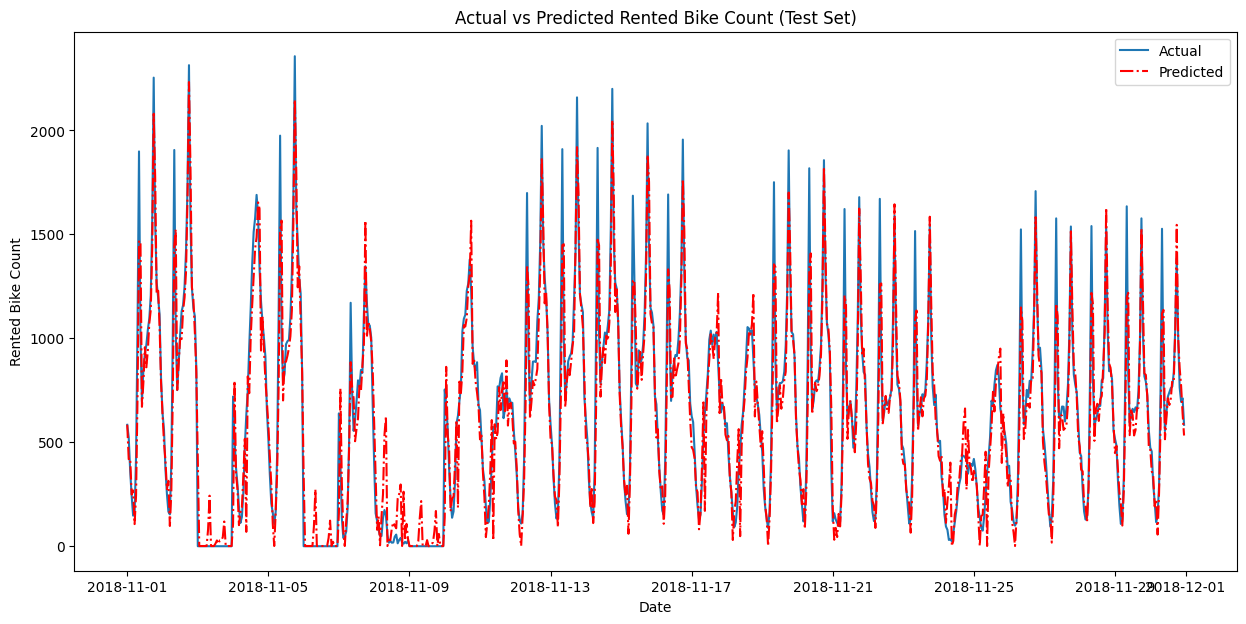

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_test_pred_lm, 'r-.', label='Predicted')
plt.title('Actual vs Predicted Rented Bike Count (Test Set)')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

## 6.2 LightGBM

In [ ]:
# from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

# Initialize the LightGBM Regressor model
lgbm_regressor = LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    n_estimators=1000,  # Use n_estimators for scikit-learn API
    random_state=42, # for reproducibility
    verbose=-1
)

# Train the LightGBM model on the original training data
lgbm_regressor.fit(X_train, y_train)


LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.9, learning_rate=0.05,
              metric='rmse', n_estimators=1000, objective='regression',
              random_state=42, verbose=-1)

### Next hour forecasting evaluation

In [ ]:
y_test_pred_lgb = lgbm_regressor.predict(X_test)
y_test_pred_lgb[y_test_pred_lgb < 0] = 1
# Evaluate the model on the training data
print("Testing R-squared:", r2_score(y_test, y_test_pred_lgb))
print("Testing MAPE:", mean_absolute_percentage_error(y_test, y_test_pred_lgb))
print("Tesing RMSE:", root_mean_squared_error(y_test, y_test_pred_lgb))
print("Testing RMSLE:", root_mean_squared_log_error(y_test, y_test_pred_lgb))

Testing R-squared: 0.9695128521134836
Testing MAPE: 7193757363292339.0
Tesing RMSE: 84.31795525336805
Testing RMSLE: 0.7421389769834914


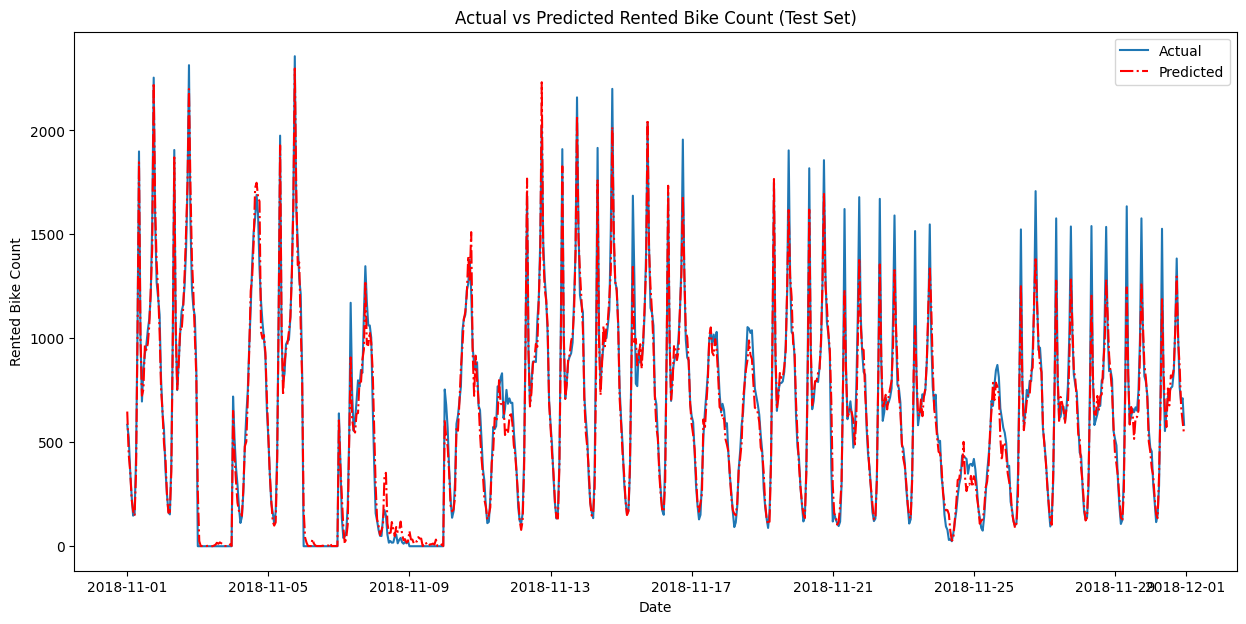

In [ ]:
# Using sns plot the test and prediction with dot line
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_test_pred_lgb, 'r-.', label='Predicted')
plt.title('Actual vs Predicted Rented Bike Count (Test Set)')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

### Dynamic forecasting: 7*24 hours
Implement dynamic forecasting by iteratively predicting the next hour's rented bike count and using that prediction as an input for the subsequent prediction, repeating this for 7 days (168 hours).


In [ ]:
# Get the last data point from the training set as the starting point for forecasting
last_train_hour_features = X_train.iloc[-1].copy()
last_train_hour_datetime = X_train.index[-1]
forecast_hours = 7 * 24  # 7 days * 24 hours
rolling_windows = 7 * 24 # Window size for rolling features (7 days)

In [ ]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ':00:00')
df.set_index('datetime', inplace=True)
df.head()

date  hourly_count hour  temperature  humidity  \
datetime                                                                   
2017-12-01 00:00:00 2017-12-01           254    0         -5.2        37   
2017-12-01 01:00:00 2017-12-01           204    1         -5.5        38   
2017-12-01 02:00:00 2017-12-01           173    2         -6.0        39   
2017-12-01 03:00:00 2017-12-01           107    3         -6.2        40   
2017-12-01 04:00:00 2017-12-01            78    4         -6.0        36   

                     wind_speed  visibility  dew_point_temperature  \
datetime                                                             
2017-12-01 00:00:00         2.2        2000                  -17.6   
2017-12-01 01:00:00         0.8        2000                  -17.6   
2017-12-01 02:00:00         1.0        2000                  -17.7   
2017-12-01 03:00:00         0.9        2000                  -17.6   
2017-12-01 04:00:00         2.3        2000                  -18.6   

                     solar_radiation  rainfall  ...      std_wd weekday_z  \
datetime                                        ...                         
2017-12-01 00:00:00              0.0       0.0  ...  658.396481 -0.748968   
2017-12-01 01:00:00              0.0       0.0  ...  658.396481 -0.824910   
2017-12-01 02:00:00              0.0       0.0  ...  658.396481 -0.871994   
2017-12-01 03:00:00              0.0       0.0  ...  658.396481 -0.972238   
2017-12-01 04:00:00              0.0       0.0  ...  658.396481 -1.016284   

                    mean_season_x std_season_x  season_z  is_anom  \
datetime                                                            
2017-12-01 00:00:00    225.541204   150.372236  0.189256    False   
2017-12-01 01:00:00    225.541204   150.372236 -0.143253    False   
2017-12-01 02:00:00    225.541204   150.372236 -0.349408    False   
2017-12-01 03:00:00    225.541204   150.372236 -0.788318    False   
2017-12-01 04:00:00    225.541204   150.372236 -0.981173    False   

                    mean_season_y std_season_y  mean_season  std_season  
datetime                                                                 
2017-12-01 00:00:00    225.541204   150.372236   225.541204  150.372236  
2017-12-01 01:00:00    225.541204   150.372236   225.541204  150.372236  
2017-12-01 02:00:00    225.541204   150.372236   225.541204  150.372236  
2017-12-01 03:00:00    225.541204   150.372236   225.541204  150.372236  
2017-12-01 04:00:00    225.541204   150.372236   225.541204  150.372236  

[5 rows x 31 columns]

In [ ]:
# Get the initial history for lagged features from the training data
end_time = last_train_hour_datetime
start_time = last_train_hour_datetime - pd.Timedelta(hours=rolling_windows - 1)
dynamic_hourly_count = df['hourly_count'].loc[start_time:end_time].copy()

# List to store dynamic predictions
dynamic_predictions = []
dynamic_forecast_index = []

In [ ]:
# Implement dynamic forecasting loop
# current_features = last_train_hour_features.copy()

for current_datetime in X_test.index[:forecast_hours]:
    # Calculate lagged features using pandas shift
    current_features = X_test.loc[current_datetime].copy()
    lagged_features = pd.DataFrame(index=[current_datetime])
    for i in range(1, 13):
        lagged_features[f"lagged_hourly_count_{i}h"] = dynamic_hourly_count.shift(i).iloc[-1]

    # Calculate rolling features using pandas rolling
    lagged_features["lagged_mean_24h"] = dynamic_hourly_count.rolling(24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_24h"] = dynamic_hourly_count.rolling(24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_24h"] = dynamic_hourly_count.rolling(24).min().shift(1).iloc[-1]
    lagged_features["lagged_mean_2d"] = dynamic_hourly_count.rolling(2 * 24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_2d"] = dynamic_hourly_count.rolling(2 * 24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_2d"] = dynamic_hourly_count.rolling(2 * 24).min().shift(1).iloc[-1]
    lagged_features["lagged_mean_3d"] = dynamic_hourly_count.rolling(3 * 24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_3d"] = dynamic_hourly_count.rolling(3 * 24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_3d"] = dynamic_hourly_count.rolling(3 * 24).min().shift(1).iloc[-1]
    lagged_features["lagged_mean_4d"] = dynamic_hourly_count.rolling(4 * 24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_4d"] = dynamic_hourly_count.rolling(4 * 24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_4d"] = dynamic_hourly_count.rolling(4 * 24).min().shift(1).iloc[-1]
    lagged_features["lagged_mean_5d"] = dynamic_hourly_count.rolling(5 * 24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_5d"] = dynamic_hourly_count.rolling(5 * 24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_5d"] = dynamic_hourly_count.rolling(5 * 24).min().shift(1).iloc[-1]
    lagged_features["lagged_mean_6d"] = dynamic_hourly_count.rolling(6 * 24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_6d"] = dynamic_hourly_count.rolling(6 * 24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_6d"] = dynamic_hourly_count.rolling(6 * 24).min().shift(1).iloc[-1]
    lagged_features["lagged_mean_7d"] = dynamic_hourly_count.rolling(7 * 24).mean().shift(1).iloc[-1]
    lagged_features["lagged_max_7d"] = dynamic_hourly_count.rolling(7 * 24).max().shift(1).iloc[-1]
    lagged_features["lagged_min_7d"] = dynamic_hourly_count.rolling(7 * 24).min().shift(1).iloc[-1]


    # Update the current features with the newly calculated lagged features
    for lag_col in lagged_features.columns:
        if lag_col in current_features.index:
            current_features[lag_col] = lagged_features[lag_col].iloc[0]

    current_features_df = pd.DataFrame([current_features])
    current_features_df.columns = X_train.columns
    current_features_df.index = [current_datetime]
    # Predict the next hour's rented bike count
    next_hour_prediction = lgbm_regressor.predict(current_features_df)

    # Append the prediction and its corresponding datetime to the lists
    dynamic_predictions.append(next_hour_prediction[0])
    dynamic_forecast_index.append(current_datetime)

    # Update dynamic_hourly_count with the new prediction
    dynamic_hourly_count = pd.concat([dynamic_hourly_count[1:], pd.Series(next_hour_prediction, index=[current_datetime])])


# Create a pandas Series for the dynamic predictions with a proper time index
dynamic_predictions_series = pd.Series(dynamic_predictions, index=dynamic_forecast_index)

display(dynamic_predictions_series.head())
display(dynamic_predictions_series.tail())

2018-11-01 00:00:00    790.049020
2018-11-01 01:00:00    598.769280
2018-11-01 02:00:00    599.170062
2018-11-01 03:00:00    453.696448
2018-11-01 04:00:00    438.815544
dtype: float64

2018-11-07 19:00:00     294.363655
2018-11-07 20:00:00    1193.064831
2018-11-07 21:00:00     363.772231
2018-11-07 22:00:00    1179.052282
2018-11-07 23:00:00     293.258349
dtype: float64

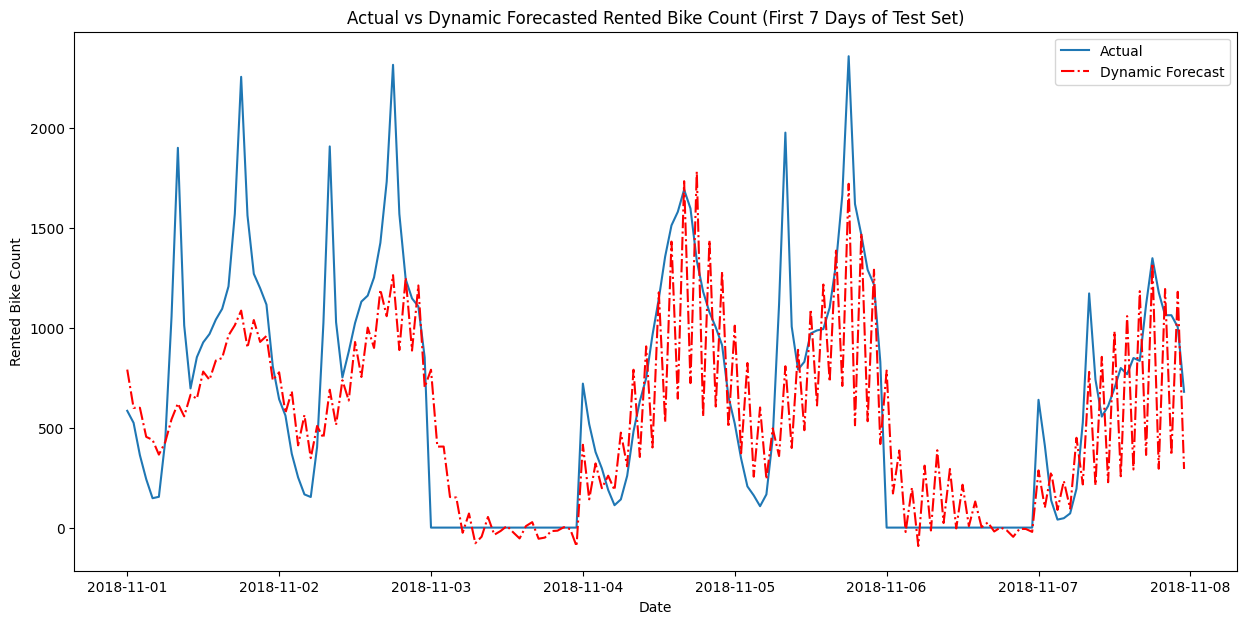

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index[:forecast_hours], y_test[:forecast_hours], label='Actual')
plt.plot(dynamic_predictions_series.index, dynamic_predictions_series, 'r-.', label='Dynamic Forecast')
plt.title('Actual vs Dynamic Forecasted Rented Bike Count (First 7 Days of Test Set)')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()